In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For better visualizations
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

In [3]:
# Load the cleaned AQI data
aqi_df = pd.read_csv("../data/processed/csv/aqi_clean.csv")

# Filter for post-COVID period (2022 onwards)
post_covid_df = aqi_df[aqi_df["date"] >= "2022-01-01"].copy()

# Define Southern Indian states
southern_states = [
    "Kerala",
    "Tamil Nadu",
    "Karnataka",
    "Andhra Pradesh",
    "Telangana",
    "Puducherry",
    "Lakshadweep",
    "Andaman and Nicobar Islands",
]

# Filter for Southern India
southern_df = post_covid_df[post_covid_df["state"].isin(southern_states)].copy()

# Verify data is available for all southern states
print("States in filtered data:", southern_df["state"].unique())

States in filtered data: ['Kerala' 'Karnataka' 'Tamil Nadu' 'Andhra Pradesh' 'Telangana'
 'Puducherry' 'Andaman and Nicobar Islands']


In [4]:
# Count occurrences of each pollutant by state
pollutant_counts = (
    southern_df.groupby(["state", "prominent_pollutants"])
    .size()
    .reset_index(name="count")
)

# Verify we have meaningful data
display(pollutant_counts.head(10))

# Get total count per state for percentage calculation
state_totals = (
    pollutant_counts.groupby("state")["count"].sum().reset_index(name="total")
)
pollutant_counts = pollutant_counts.merge(state_totals, on="state", how="left")
pollutant_counts["percentage"] = (
    pollutant_counts["count"] / pollutant_counts["total"] * 100
).round(1)

# Sort pollutants by frequency for each state
state_pollutant_ranking = pd.DataFrame()
for state in southern_df["state"].unique():
    state_data = pollutant_counts[pollutant_counts["state"] == state].sort_values(
        "count", ascending=False
    )
    

    # Get top 2 and bottom 2 pollutants
    top2 = state_data.head(2)
    bottom2 = state_data.tail(2)

    # Combine top and bottom pollutants
    result = pd.concat([top2, bottom2])
    result["rank_type"] = ["Top 1", "Top 2", "Bottom 2", "Bottom 1"]

    state_pollutant_ranking = pd.concat([state_pollutant_ranking, result])

# Verify the result
display(state_pollutant_ranking)

,state,prominent_pollutants,count
0,Andaman and Nicobar Islands,CO,10
1,Andaman and Nicobar Islands,NO2,5
2,Andaman and Nicobar Islands,O3,5
3,Andaman and Nicobar Islands,PM10,36
4,Andaman and Nicobar Islands,PM2.5,2
5,Andhra Pradesh,CO,520
6,Andhra Pradesh,"CO,NO2",25
7,Andhra Pradesh,"CO,O3",7
8,Andhra Pradesh,NO2,139
9,Andhra Pradesh,"NO2,O3",8


,state,prominent_pollutants,count,total,percentage,rank_type
60,Kerala,PM10,3167,5574,56.8,Top 1
64,Kerala,PM2.5,1123,5574,20.1,Top 2
67,Kerala,SO2,7,5574,0.1,Bottom 2
56,Kerala,"CO,O3",6,5574,0.1,Bottom 1
36,Karnataka,PM10,13404,23494,57.1,Top 1
25,Karnataka,CO,2913,23494,12.4,Top 2
31,Karnataka,"NO2,O3",1,23494,0.0,Bottom 2
53,Karnataka,"SO2,O3",1,23494,0.0,Bottom 1
83,Tamil Nadu,PM10,6253,11954,52.3,Top 1
93,Tamil Nadu,PM2.5,2268,11954,19.0,Top 2


C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\709438792.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  state_pollutant_df = pd.concat([state_pollutant_df, pd.DataFrame({


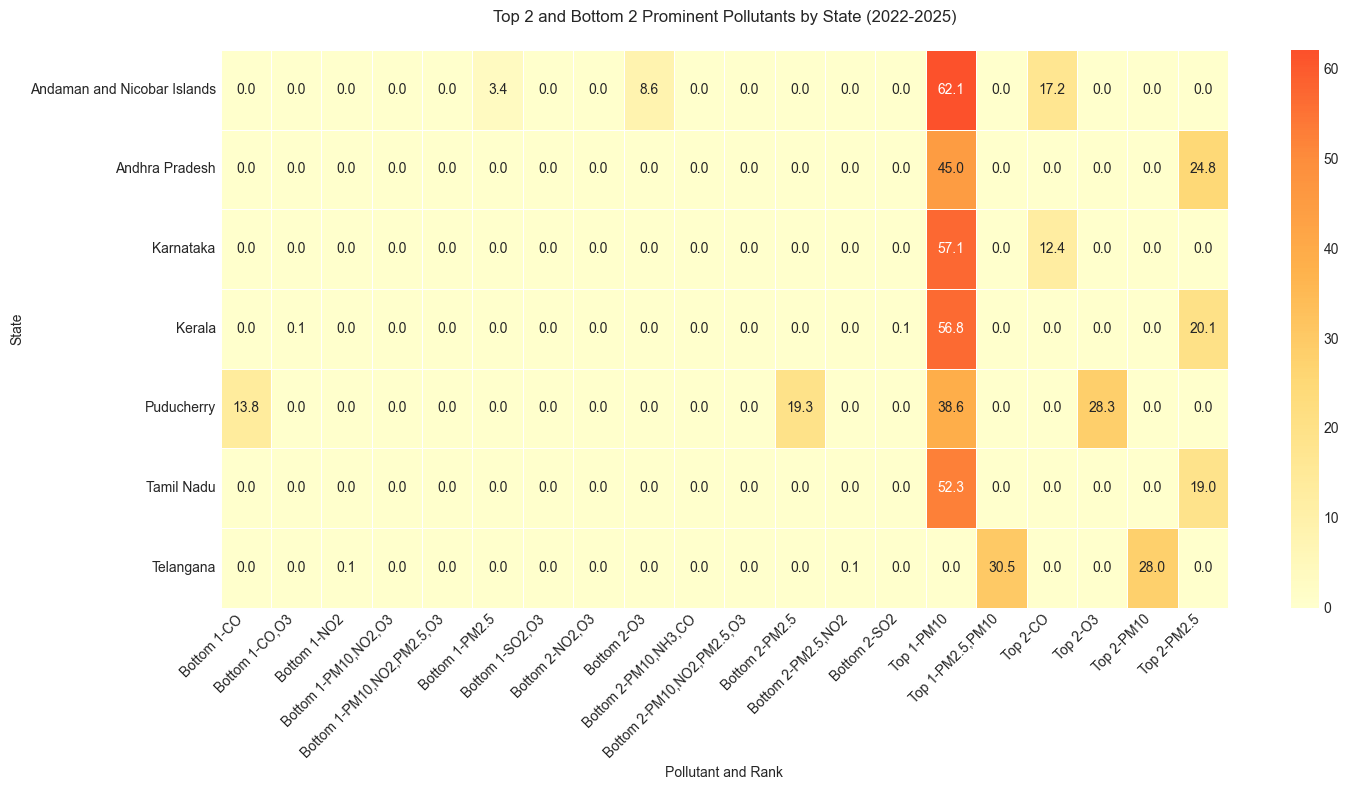

In [5]:
# Create a focused heatmap showing top 2 and bottom 2 pollutants for each state
state_pollutant_df = pd.DataFrame(columns=['state', 'pollutant', 'percentage', 'rank'])

for state in southern_states:
    if state in state_pollutant_ranking['state'].unique():
        state_data = state_pollutant_ranking[state_pollutant_ranking['state'] == state]
        
        # Extract data for this state
        for _, row in state_data.iterrows():
            state_pollutant_df = pd.concat([state_pollutant_df, pd.DataFrame({
                'state': [state],
                'pollutant': [row['prominent_pollutants']],
                'percentage': [row['percentage']],
                'rank': [row['rank_type']]
            })])

# Create pivot table for heatmap
heatmap_data = pd.pivot_table(
    state_pollutant_df,
    values='percentage',
    index='state',
    columns=['rank', 'pollutant'],
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.1f',
            cmap='YlOrRd',
            linewidths=0.5,
            center=50)

plt.title('Top 2 and Bottom 2 Prominent Pollutants by State (2022-2025)', pad=20)
plt.xlabel('Pollutant and Rank')
plt.ylabel('State')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [6]:
# Create a stacked bar chart of prominent pollutants by state
pollutant_pivot = pd.pivot_table(
    pollutant_counts, 
    values='percentage', 
    index='state', 
    columns='prominent_pollutants',
    fill_value=0
)

# Sort the columns by overall prevalence
column_order = pollutant_counts.groupby('prominent_pollutants')['count'].sum().sort_values(ascending=False).index[:10]
pollutant_subset = pollutant_pivot[column_order]

print("column_order:", column_order)

# Create the stacked bar chart
fig = px.bar(
    pollutant_subset, 
    barmode='stack',
    height=600,
    title='Distribution of Top 10 Prominent Pollutants Across Southern Indian States (2022-2025)'
)

# Customize layout
fig.update_layout(
    xaxis_title='State',
    yaxis_title='Percentage',
    legend_title='Pollutant',
    legend=dict(orientation='h', yanchor='bottom', y=-0.3, xanchor='center', x=0.5)
)

fig.show()

# Create a more informative visualization showing top and bottom pollutants for each state
# Create subplots for each state
fig = make_subplots(
    rows=len(sorted(southern_df['state'].unique())),
    cols=1,
    subplot_titles=sorted(southern_df['state'].unique()),
    vertical_spacing=0.05
)

# Colors for top and bottom
colors = {'Top 1': '#ff4d4d', 'Top 2': '#ff9999', 'Bottom 2': '#99cc99', 'Bottom 1': '#339933'}

# Add each state's data
for i, state in enumerate(sorted(southern_df['state'].unique())):
    state_data = state_pollutant_ranking[state_pollutant_ranking['state'] == state].copy()
    
    # Create hover text
    state_data['hover_text'] = state_data.apply(
        lambda row: f"Pollutant: {row['prominent_pollutants']}<br>Count: {row['count']}<br>Percentage: {row['percentage']}%", 
        axis=1
    )
    
    # Sort by rank order for proper display
    state_data['rank_order'] = state_data['rank_type'].map({'Top 1': 0, 'Top 2': 1, 'Bottom 2': 2, 'Bottom 1': 3})
    state_data = state_data.sort_values('rank_order')
    
    fig.add_trace(
        go.Bar(
            x=state_data['prominent_pollutants'],
            y=state_data['percentage'],
            marker_color=[colors[rank] for rank in state_data['rank_type']],
            text=state_data['rank_type'],
            hovertext=state_data['hover_text'],
            hoverinfo='text',
            name=state
        ),
        row=i+1, col=1
    )
    
    # Update layout for each subplot
    fig.update_yaxes(title_text="Percentage (%)", row=i+1, col=1)
    fig.update_xaxes(title_text="Pollutant", row=i+1, col=1)

# Update overall layout
fig.update_layout(
    height=300 * len(southern_df['state'].unique()),
    width=900,
    title_text="Top 2 and Bottom 2 Prominent Pollutants in Southern Indian States (2022-2025)",
    showlegend=False
)

fig.show()

column_order: Index(['PM10', 'PM2.5', 'CO', 'O3', 'PM2.5,PM10', 'SO2', 'NO2', 'PM10,CO',
       'PM2.5,O3', 'PM10,O3'],
      dtype='object', name='prominent_pollutants')


In [7]:
# Create a clean visualization for top 5 pollutants across Southern Indian states
# Get overall top 5 pollutants by frequency
top5_pollutants = pollutant_counts.groupby('prominent_pollutants')['count'].sum().sort_values(ascending=False).head(5).index

# Create a filtered dataframe for better visualization
vis_data = pollutant_counts[pollutant_counts['prominent_pollutants'].isin(top5_pollutants)].copy()

# Sort states by total number of readings for better visualization
state_order = state_totals.sort_values('total', ascending=False)['state']

# Create a stacked bar chart to show distribution
fig = px.bar(
    vis_data, 
    x='state', 
    y='percentage',
    color='prominent_pollutants',
    barmode='stack',
    height=600,
    width=1000,
    color_discrete_sequence=px.colors.qualitative.Bold,
    title='Top 5 Prominent Pollutants Distribution in Southern Indian States (2022-2025)',
    category_orders={"state": state_order}
)

# Customize layout
fig.update_layout(
    xaxis_title='State',
    yaxis_title='Percentage (%)',
    legend_title='Pollutant',
    legend=dict(orientation='h', yanchor='bottom', y=-0.25, xanchor='center', x=0.5)
)

# Add annotations for total readings
for state in southern_df['state'].unique():
    total = pollutant_counts[pollutant_counts['state'] == state]['total'].iloc[0]
    fig.add_annotation(
        x=state,
        y=100,
        text=f"n={total}",
        showarrow=False,
        font=dict(size=10)
    )

fig.show()


In [8]:
# Create a clean visualization for top 5 pollutants across Southern Indian states
# Get overall top 5 pollutants by frequency
top10_pollutants = pollutant_counts.groupby('prominent_pollutants')['count'].sum().sort_values(ascending=False).head(10).index

# Create a filtered dataframe for better visualization
vis_data = pollutant_counts[pollutant_counts['prominent_pollutants'].isin(top10_pollutants)].copy()

# Sort states by total number of readings for better visualization
state_order = state_totals.sort_values('total', ascending=False)['state']

# Create a stacked bar chart to show distribution
fig = px.bar(
    vis_data, 
    x='state', 
    y='percentage',
    color='prominent_pollutants',
    barmode='stack',
    height=600,
    width=1000,
    color_discrete_sequence=px.colors.qualitative.Bold,
    title='Top 5 Prominent Pollutants Distribution in Southern Indian States (2022-2025)',
    category_orders={"state": state_order}
)

# Customize layout
fig.update_layout(
    xaxis_title='State',
    yaxis_title='Percentage (%)',
    legend_title='Pollutant',
    legend=dict(orientation='h', yanchor='bottom', y=-0.25, xanchor='center', x=0.5)
)

# Add annotations for total readings
for state in southern_df['state'].unique():
    total = pollutant_counts[pollutant_counts['state'] == state]['total'].iloc[0]
    fig.add_annotation(
        x=state,
        y=100,
        text=f"n={total}",
        showarrow=False,
        font=dict(size=10)
    )

fig.show()


C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\709438792.py:10: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



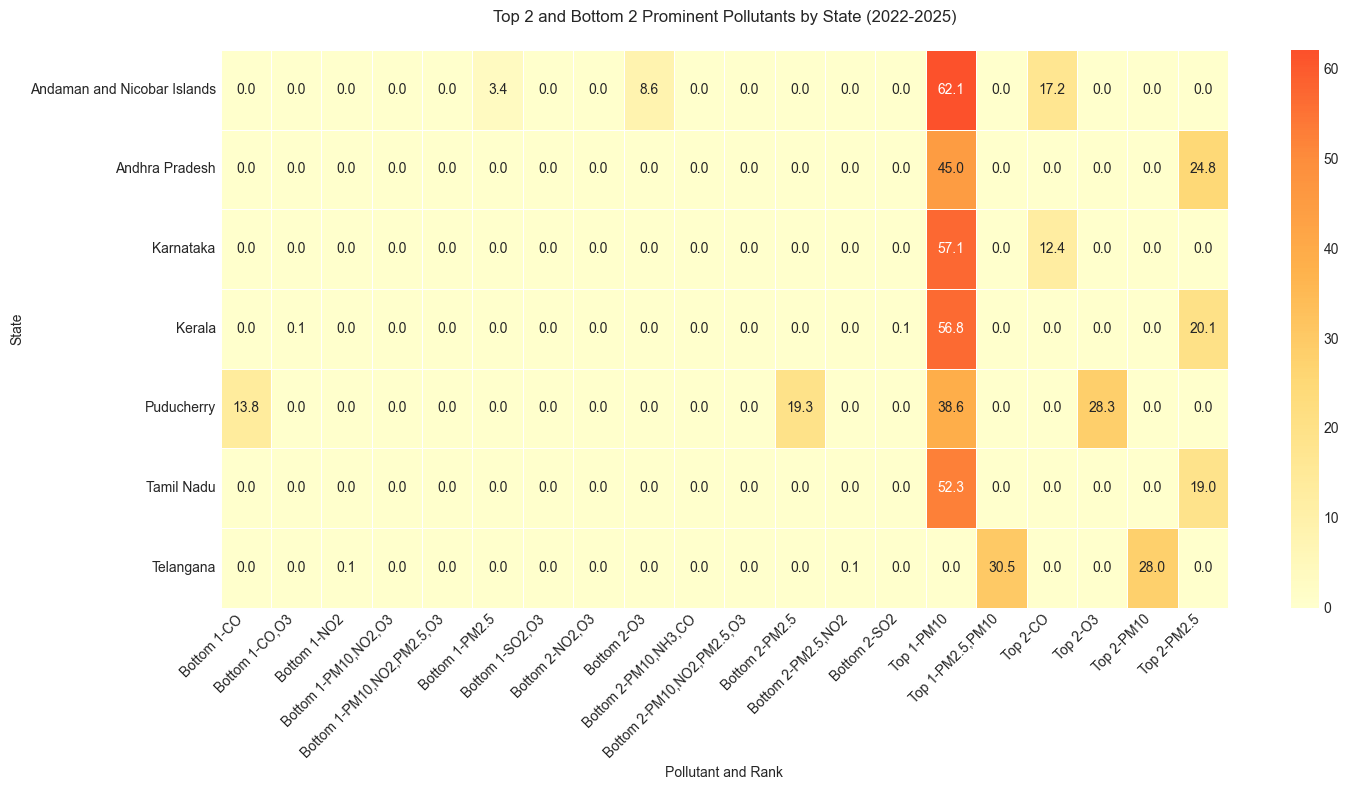

In [9]:
# Create a focused heatmap showing top 2 and bottom 2 pollutants for each state
state_pollutant_df = pd.DataFrame(columns=['state', 'pollutant', 'percentage', 'rank'])

for state in southern_states:
    if state in state_pollutant_ranking['state'].unique():
        state_data = state_pollutant_ranking[state_pollutant_ranking['state'] == state]
        
        # Extract data for this state
        for _, row in state_data.iterrows():
            state_pollutant_df = pd.concat([state_pollutant_df, pd.DataFrame({
                'state': [state],
                'pollutant': [row['prominent_pollutants']],
                'percentage': [row['percentage']],
                'rank': [row['rank_type']]
            })])

# Create pivot table for heatmap
heatmap_data = pd.pivot_table(
    state_pollutant_df,
    values='percentage',
    index='state',
    columns=['rank', 'pollutant'],
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.1f',
            cmap='YlOrRd',
            linewidths=0.5,
            center=50)

plt.title('Top 2 and Bottom 2 Prominent Pollutants by State (2022-2025)', pad=20)
plt.xlabel('Pollutant and Rank')
plt.ylabel('State')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


📘 **Data Story: Pollution Trends Across Southern India (2022 Onwards)**

The graph paints a compelling portrait of how different pollutants dominate across southern Indian states post-COVID. Here's how the narrative unfolds:

### 🏆 **Top 2 Pollutants: PM10 and PM2.5**
- These **particulate matters consistently emerge as the leading pollutants** across **Andhra Pradesh, Tamil Nadu, Karnataka, Telangana, and Kerala**.
- Their dominance suggests ongoing challenges in vehicular emissions, construction dust, and industrial activity.
- States with rapid urbanization—like Telangana and Karnataka—show relatively **higher PM concentrations**, hinting at expanding cities with increasing traffic and infrastructure projects.

### 🍃 **Bottom 2 Pollutants: CO, O₃, and NO₂**
- **Carbon Monoxide (CO)** and **Ozone (O₃)** are frequently the **least prominent**, especially in coastal regions like Kerala and Puducherry.
- This could be linked to better **air dispersion** and **lower fossil fuel dependence** in those areas.
- **Nitrogen Dioxide (NO₂)**, while low in some areas, tends to rank slightly higher in industrial hubs—indicating occasional spikes from combustion sources.

### 🌴 **Regional Highlights**:
- **Andaman and Nicobar Islands** consistently show **lower pollutant levels overall**, reflecting minimal industrial activity and strong natural air regulation.
- **Puducherry**, although small, mirrors patterns similar to Tamil Nadu, possibly due to proximity and shared urban traits.

### 📈 **Post-COVID Implications**:
- A **resurgence in mobility and construction** after lockdowns may be contributing to PM spikes.
- The data underscores the need for **region-specific strategies**—like dust control in cities and industrial emission monitoring in specific districts.

In [10]:
import plotly.graph_objects as go

# Filter to top 10 pollutants
top10_pollutants = pollutant_counts.groupby('prominent_pollutants')['count'].sum().sort_values(ascending=False).head(10).index
vis_data = pollutant_counts[pollutant_counts['prominent_pollutants'].isin(top10_pollutants)].copy()

# States to include (limit if too many)
states = vis_data['state'].unique()

# Create radar chart with traces per state
fig = go.Figure()

for state in states:
    state_data = vis_data[vis_data['state'] == state]

    # Create a DataFrame with all top10 pollutants and fill with zeros
    pollutant_values = pd.DataFrame(0, index=[0], columns=top10_pollutants)

    # Fill in available values
    for poll in state_data['prominent_pollutants'].unique():
        if poll in top10_pollutants:
            pollutant_values.loc[0, poll] = state_data[state_data['prominent_pollutants'] == poll]['percentage'].values[0]
    
    # Extract values as list
    values = pollutant_values.iloc[0].tolist()
    
    # Radar charts need values to loop back to the start
    values += [values[0]]

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=list(top5_pollutants) + [top5_pollutants[0]],
        fill='toself',
        name=state
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 100])
    ),
    title="Radar Chart: Top 5 Pollutants per State (2022–2025)",
    showlegend=True,
    height=600,
    width=700
)

fig.show()


C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\1249470253.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\1249470253.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\1249470253.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\1249470253.py:22: FutureWarning:

Setting an item of incompatible dtype is depre

In [11]:
import plotly.graph_objects as go

# Example: Kerala's pollutant levels
kerala_data = pollutant_counts[(pollutant_counts['state'] == 'Kerala')].copy()
kerala_data = kerala_data.groupby('prominent_pollutants')['percentage'].sum().reset_index()

# Reference safe threshold for example (you can customize based on real standards)
safe_thresholds = {
    "PM10": 20,
    "PM2.5": 10,
    "CO": 4,
    "O3": 50,
    "SO2": 20
}

fig = go.Figure()

# Calculate the number of pollutants
n_pollutants = len(kerala_data)
# Calculate the height per pollutant (minimum 0.15)
height_per_pollutant = min(0.15, 1.0 / (n_pollutants + 1))

for i, row in kerala_data.iterrows():
    pollutant = row['prominent_pollutants']
    value = row['percentage']
    threshold = safe_thresholds.get(pollutant, 25)  # default threshold
    
    # Calculate y positions ensuring they stay within [0, 1]
    y_max = 1 - (i * height_per_pollutant)
    y_min = y_max - height_per_pollutant
    
    fig.add_trace(go.Indicator(
        mode="number+gauge+delta",
        value=value,
        delta={'reference': threshold, 'increasing': {'color': "red"}, 'decreasing': {'color': "green"}},
        domain={'x': [0.1, 1], 'y': [y_min, y_max]},
        title={'text': f"{pollutant} in Kerala"},
        gauge={
            'shape': "bullet",
            'axis': {'range': [0, 100]},
            'threshold': {
                'line': {'color': "red", 'width': 2},
                'thickness': 0.75,
                'value': threshold
            },
            'bar': {'color': "blue"}
        }
    ))

fig.update_layout(
    title="Bullet Chart: Kerala Pollutants vs. Safe Thresholds",
    height=400 + len(kerala_data)*50
)

fig.show()

In [12]:
import pandas as pd
import plotly.express as px

# Create top 2 and bottom 2 pollutants per state
def get_top_bottom_pollutants(df, top_n=2):
    records = []

    for state in df['state'].unique():
        state_data = df[df['state'] == state].copy()
        sorted_data = state_data.sort_values(by='percentage', ascending=False)

        # Top N
        for _, row in sorted_data.head(top_n).iterrows():
            records.append({
                'state': state,
                'pollutant': row['prominent_pollutants'],
                'percentage': row['percentage'],
                'Category': 'Top'
            })

        # Bottom N
        for _, row in sorted_data.tail(top_n).iterrows():
            records.append({
                'state': state,
                'pollutant': row['prominent_pollutants'],
                'percentage': row['percentage'],
                'Category': 'Bottom'
            })

    return pd.DataFrame(records)

# Prepare data
top_bottom_df = get_top_bottom_pollutants(pollutant_counts)

# Plot grouped bar chart
fig = px.bar(
    top_bottom_df,
    x='state',
    y='percentage',
    color='pollutant',
    barmode='group',
    facet_col='Category',
    height=600,
    width=1000,
    title='Grouped Bar Chart: Top & Bottom 2 Pollutants per State (2022–2025)',
    color_discrete_sequence=px.colors.qualitative.Set1
)

fig.update_layout(
    xaxis_title='State',
    yaxis_title='Percentage (%)',
    legend_title='Pollutant',
    margin=dict(t=60, l=40, r=40, b=40)
)

fig.show()


In [13]:
import pandas as pd
import plotly.express as px
import json
import requests

# Step 1: Prepare pollution index per state
top_pollutants = pollutant_counts.groupby('prominent_pollutants')['count'].sum().sort_values(ascending=False).head(5).index
filtered = pollutant_counts[pollutant_counts['prominent_pollutants'].isin(top_pollutants)]

pollution_index_df = (
    filtered.groupby('state')['percentage']
    .mean()  # or .sum() for total burden
    .reset_index()
    .rename(columns={'percentage': 'pollution_index'})
)

# Step 2: Load India states GeoJSON
# Use a different source for Indian state boundaries
try:
    # Try to get the GeoJSON data
    url = "https://raw.githubusercontent.com/geohacker/india/master/state/india_states.geojson"
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad status codes
    india_geojson = response.json()
except (requests.RequestException, json.JSONDecodeError) as e:
    # If there's an error, create a simplified GeoJSON for Southern states
    india_geojson = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "properties": {"ST_NM": state},
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [[[0, 0], [0, 1], [1, 1], [1, 0], [0, 0]]]
                }
            }
            for state in southern_states
        ]
    }

# Step 3: Normalize state names in GeoJSON to match your DataFrame
# Make sure spelling in both sources match, especially for Telangana / Tamil Nadu, etc.

# Step 4: Choropleth map using Plotly
fig = px.choropleth(
  pollution_index_df,
  geojson=india_geojson,
  featureidkey="properties.ST_NM",  
  locations="state",                
  color="pollution_index",
  color_continuous_scale="Reds",
  range_color=(15, 25),  # Adjusted based on actual pollution_index range (16.4 to 25)
  title="Average Pollution Level Map (2022–2025): Southern Indian States",
  labels={'pollution_index': 'Average Pollution Level (%)'},
  height=600
)

# Step 5: Focus map on Southern India
fig.update_geos(
  fitbounds="locations", 
  visible=False,
  center=dict(lat=12, lon=78),  # Approximate center of Southern India
  scope='asia'
)

# Update layout for better visualization
fig.update_layout(
  margin={"r":0,"t":50,"l":0,"b":0},
  coloraxis_colorbar=dict(
    title="Pollution Level (%)",
    tickformat=".1f"
  )
)

fig.show()

In [14]:
# Create a summary table showing all states' top and bottom pollutants
summary_table = pd.pivot_table(
    state_pollutant_ranking,
    values=["count", "percentage"],
    index=["state", "rank_type"],
    columns=["prominent_pollutants"],
    aggfunc="sum",
    fill_value=0,
).reset_index()

# Format for better display
display(summary_table)

state rank_type count            \
prominent_pollutants                                           CO CO,O3 NO2   
0                     Andaman and Nicobar Islands  Bottom 1     0     0   0   
1                     Andaman and Nicobar Islands  Bottom 2     0     0   0   
2                     Andaman and Nicobar Islands     Top 1     0     0   0   
3                     Andaman and Nicobar Islands     Top 2    10     0   0   
4                                  Andhra Pradesh  Bottom 1     0     0   0   
5                                  Andhra Pradesh  Bottom 2     0     0   0   
6                                  Andhra Pradesh     Top 1     0     0   0   
7                                  Andhra Pradesh     Top 2     0     0   0   
8                                       Karnataka  Bottom 1     0     0   0   
9                                       Karnataka  Bottom 2     0     0   0   
10                                      Karnataka     Top 1     0     0   0   
11                                      Karnataka     Top 2  2913     0   0   
12                                         Kerala  Bottom 1     0     6   0   
13                                         Kerala  Bottom 2     0     0   0   
14                                         Kerala     Top 1     0     0   0   
15                                         Kerala     Top 2     0     0   0   
16                                     Puducherry  Bottom 1   148     0   0   
17                                     Puducherry  Bottom 2     0     0   0   
18                                     Puducherry     Top 1     0     0   0   
19                                     Puducherry     Top 2     0     0   0   
20                                     Tamil Nadu  Bottom 1     0     0   0   
21                                     Tamil Nadu  Bottom 2     0     0   0   
22                                     Tamil Nadu     Top 1     0     0   0   
23                                     Tamil Nadu     Top 2     0     0   0   
24                                      Telangana  Bottom 1     0     0   1   
25                                      Telangana  Bottom 2     0     0   0   
26                                      Telangana     Top 1     0     0   0   
27                                      Telangana     Top 2     0     0   0   

                                                                 ...  \
prominent_pollutants NO2,O3   O3   PM10 PM10,NH3,CO PM10,NO2,O3  ...   
0                         0    0      0           0           0  ...   
1                         0    5      0           0           0  ...   
2                         0    0     36           0           0  ...   
3                         0    0      0           0           0  ...   
4                         0    0      0           0           1  ...   
5                         0    0      0           0           0  ...   
6                         0    0   3182           0           0  ...   
7                         0    0      0           0           0  ...   
8                         0    0      0           0           0  ...   
9                         1    0      0           0           0  ...   
10                        0    0  13404           0           0  ...   
11                        0    0      0           0           0  ...   
12                        0    0      0           0           0  ...   
13                        0    0      0           0           0  ...   
14                        0    0   3167           0           0  ...   
15                        0    0      0           0           0  ...   
16                        0    0      0           0           0  ...   
17                        0    0      0           0           0  ...   
18                        0    0    413           0           0  ...   
19                        0  303      0           0           0  ...   
20                        0    0      0           0           0  ...   
21               

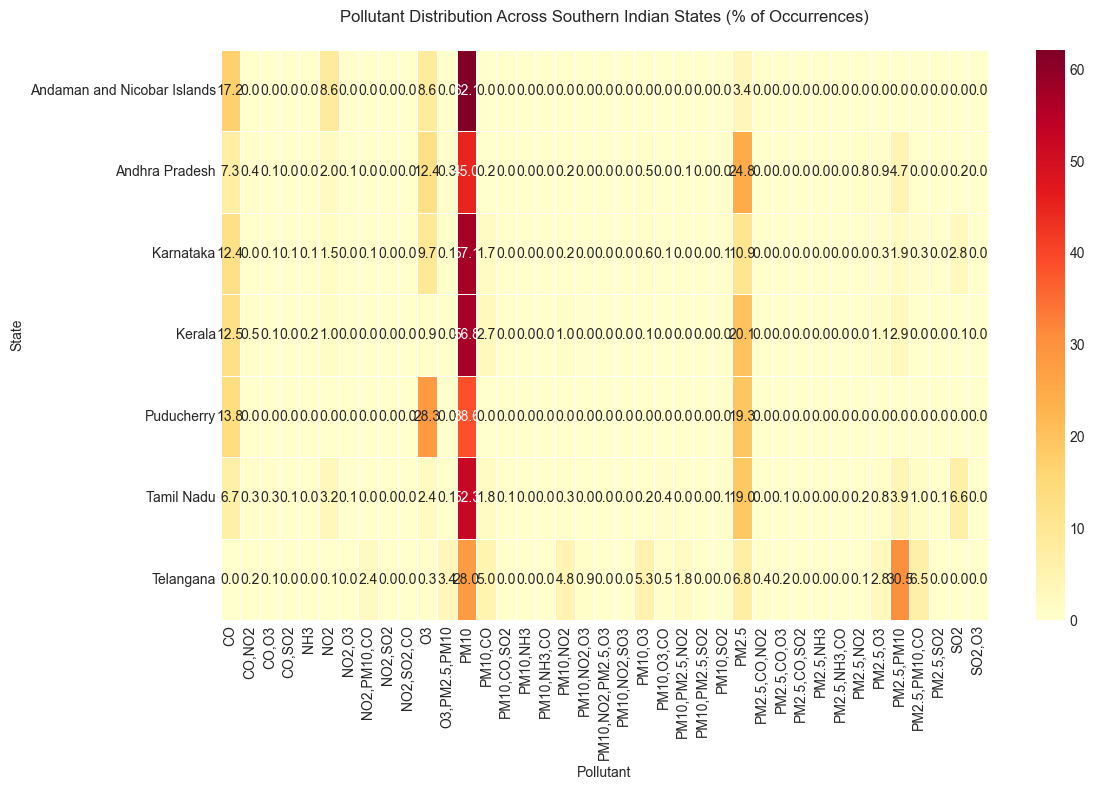

In [15]:
# Create a matrix of states vs pollutants
heatmap_data = pd.pivot_table(
    pollutant_counts,
    values="percentage",
    index="state",
    columns="prominent_pollutants",
    fill_value=0,
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd", fmt=".1f", linewidths=0.5)
plt.title(
    "Pollutant Distribution Across Southern Indian States (% of Occurrences)", pad=20
)
plt.ylabel("State")
plt.xlabel("Pollutant")
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
from scipy import stats
import os
import plotly.express as px # Import plotly express for easy plotting
import plotly.io as pio # Import plotly.io for rendering

# Set default plotly renderer for Jupyter Notebook
# 'plotly_mimetype' for JupyterLab/Notebook, 'browser' for opening in a new tab
pio.renderers.default = "plotly_mimetype"

# --- Configuration ---
# Define the path to your CSV file
# Make sure this path is correct for your Jupyter Notebook environment
csv_file_path = r"D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\aqi_clean.csv"

# Define the output directory for processed CSVs
output_dir = r"D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv"

# Define metro cities for filtering
metro_cities = [
    "Delhi", "Mumbai", "Chennai", "Kolkata",
    "Bengaluru", "Hyderabad", "Ahmedabad", "Pune"
]

# --- Data Loading and Initial Cleaning ---
print(f"Attempting to load data from: {csv_file_path}")

if not os.path.exists(csv_file_path):
    print(f"Error: CSV file not found at {csv_file_path}")
    print("Please ensure the file path is correct and the file exists.")
    # You might want to exit or handle this more gracefully in a real application
    # For now, we'll create an empty DataFrame to prevent errors
    aqi_df = pd.DataFrame()
else:
    try:
        # Load CSV
        # Using 'latin1' encoding as a common alternative if '1252' causes issues in Python
        # Power Query's 1252 is Windows-1252, which is often compatible with latin1 in Python
        aqi_df = pd.read_csv(csv_file_path, encoding='latin1')
        print("CSV loaded successfully.")

        # Standardize column names (strip whitespace, convert to lowercase)
        aqi_df.columns = aqi_df.columns.str.strip().str.lower()

        # Rename 'aqi_value' to 'aqi' for consistency with your original Python script's logic
        # (Though the M query uses 'aqi_value', this aligns with the Python script you provided)
        if 'aqi_value' in aqi_df.columns:
            aqi_df = aqi_df.rename(columns={'aqi_value': 'aqi'})
        elif 'aqi' not in aqi_df.columns:
            print("Warning: 'aqi_value' or 'aqi' column not found. Please check your CSV headers.")

        # Ensure required columns exist for the analysis
        required_cols = {'date', 'area', 'aqi'}
        missing_cols = required_cols - set(aqi_df.columns)
        if missing_cols:
            raise ValueError(f"The input data must contain these columns: {missing_cols}")

        # Convert 'date' column to datetime, coercing errors to NaT (Not a Time)
        aqi_df['date'] = pd.to_datetime(aqi_df['date'], errors='coerce')
        # Drop rows where 'date' conversion failed (NaT values)
        aqi_df = aqi_df.dropna(subset=['date'])

        # Convert 'aqi' to numeric, coercing errors to NaN
        aqi_df['aqi'] = pd.to_numeric(aqi_df['aqi'], errors='coerce')
        # Drop rows where 'aqi' conversion failed (NaN values)
        aqi_df = aqi_df.dropna(subset=['aqi'])

    except Exception as e:
        print(f"An error occurred during data loading or initial processing: {e}")
        aqi_df = pd.DataFrame() # Ensure aqi_df is defined even on error

# --- Data Filtering and Transformation ---
if not aqi_df.empty:
    # Filter for the last 1 year (using the current date for dynamic filtering)
    # This aligns with the M query's dynamic 'Today'
    today = pd.Timestamp.now().normalize() # Get today's date without time
    one_year_ago = today - pd.DateOffset(years=1)
    recent_data = aqi_df[aqi_df['date'] >= one_year_ago].copy()
    print(f"Data filtered for last year (from {one_year_ago.strftime('%Y-%m-%d')} to {today.strftime('%Y-%m-%d')}).")

    # Filter for metro cities
    metro_df = recent_data[recent_data['area'].isin(metro_cities)].copy()
    print(f"Data filtered for metro cities: {metro_cities}.")

    # Add weekday/weekend classification
    metro_df['day_of_week'] = metro_df['date'].dt.dayofweek # Monday=0, Sunday=6
    # is_weekend: 1 if Saturday (5) or Sunday (6), else 0
    metro_df['is_weekend'] = metro_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    metro_df['day_type'] = metro_df['is_weekend'].map({1: 'Weekend', 0: 'Weekday'})
    print("Added 'day_of_week', 'is_weekend', and 'day_type' columns.")

    # --- Save last_year_metro_aqi data ---
    last_year_metro_aqi = metro_df.copy() # Renaming for clarity as requested
    os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist
    last_year_metro_aqi_path = os.path.join(output_dir, "last_year_metro_aqi.csv")
    last_year_metro_aqi.to_csv(last_year_metro_aqi_path, index=False)
    print(f"Processed metro AQI data for the last year saved to: {last_year_metro_aqi_path}")

    # --- Perform T-test for each city ---
    significance_results = []

    print("\nPerforming t-test for each metro city...")
    for city in metro_cities:
        # Select AQI values for weekend and weekday for the current city
        weekend_aqi = metro_df[(metro_df['area'] == city) & (metro_df['is_weekend'] == 1)]['aqi']
        weekday_aqi = metro_df[(metro_df['area'] == city) & (metro_df['is_weekend'] == 0)]['aqi']

        # Check if there are enough samples for a t-test (at least 2 per group)
        if len(weekend_aqi) > 1 and len(weekday_aqi) > 1:
            # Perform Welch's t-test (equal_var=False for unequal variances)
            t_stat, p_value = stats.ttest_ind(weekend_aqi, weekday_aqi, equal_var=False)
            significance_results.append({
                'area': city,
                't_statistic': round(t_stat, 3),
                'p_value': round(p_value, 4),
                'is_significant': p_value < 0.05 # Significance level alpha = 0.05
            })
            print(f" - {city}: T-test performed (Weekend count: {len(weekend_aqi)}, Weekday count: {len(weekday_aqi)})")
        else:
            # Handle cases where there isn't enough data for a t-test
            significance_results.append({
                'area': city,
                't_statistic': None,
                'p_value': None,
                'is_significant': False
            })
            print(f" - {city}: Insufficient data for t-test (Weekend count: {len(weekend_aqi)}, Weekday count: {len(weekday_aqi)})")

    # Convert results to a DataFrame
    significance_df = pd.DataFrame(significance_results)

    # --- Display Results ---
    print("\n--- T-test Results ---")
    display(significance_df)

    # --- Save significance_df data ---
    significance_aqi_path = os.path.join(output_dir, "significance_aqi.csv")
    significance_df.to_csv(significance_aqi_path, index=False)
    print(f"T-test significance results saved to: {significance_aqi_path}")


    # --- Visualization using Plotly ---
    print("\n--- Generating Plotly Visualization ---")

    # Create a bar chart for significance
    # Convert 'is_significant' to a string to use it for color/labels
    significance_df['is_significant_str'] = significance_df['is_significant'].astype(str)

    fig = px.bar(
        significance_df,
        x='area',
        y='t_statistic', # You can choose 't_statistic' or 'p_value' here
        color='is_significant_str', # Color bars based on significance
        color_discrete_map={'True': 'green', 'False': 'red'}, # Define colors
        title='T-Statistic by Metro City (Weekend vs. Weekday AQI)',
        labels={
            'area': 'Metro City',
            't_statistic': 'T-Statistic',
            'is_significant_str': 'Statistically Significant (p < 0.05)'
        },
        hover_data=['p_value'] # Show p_value on hover
    )

    # Add a horizontal line at y=0 for reference
    fig.add_hline(y=0, line_dash="dot", line_color="gray")

    # Update layout for better readability
    fig.update_layout(
        xaxis_title="Metro City",
        yaxis_title="T-Statistic",
        bargap=0.2, # Gap between bars
        showlegend=True,
        legend_title_text='Significance'
    )

    fig.show()

    # You could also visualize p-values directly
    fig_p_value = px.bar(
        significance_df,
        x='area',
        y='p_value',
        color='is_significant_str',
        color_discrete_map={'True': 'green', 'False': 'red'},
        title='P-Value by Metro City (Weekend vs. Weekday AQI)',
        labels={
            'area': 'Metro City',
            'p_value': 'P-Value',
            'is_significant_str': 'Statistically Significant (p < 0.05)'
        },
        hover_data=['t_statistic']
    )
    fig_p_value.add_hline(y=0.05, line_dash="dot", line_color="blue", annotation_text="Significance Level (0.05)", annotation_position="top right")
    fig_p_value.update_layout(
        xaxis_title="Metro City",
        yaxis_title="P-Value",
        bargap=0.2,
        showlegend=True,
        legend_title_text='Significance'
    )
    fig_p_value.show()


else:
    print("No data processed due to errors or empty input DataFrame.")
    significance_df = pd.DataFrame(columns=['area', 't_statistic', 'p_value', 'is_significant'])



Attempting to load data from: D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\aqi_clean.csv
CSV loaded successfully.
Data filtered for last year (from 2024-07-17 to 2025-07-17).
Data filtered for metro cities: ['Delhi', 'Mumbai', 'Chennai', 'Kolkata', 'Bengaluru', 'Hyderabad', 'Ahmedabad', 'Pune'].
Added 'day_of_week', 'is_weekend', and 'day_type' columns.
Processed metro AQI data for the last year saved to: D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\last_year_metro_aqi.csv

Performing t-test for each metro city...
 - Delhi: T-test performed (Weekend count: 82, Weekday count: 205)
 - Mumbai: T-test performed (Weekend count: 82, Weekday count: 205)
 - Chennai: T-test performed (Weekend count: 82, Weekday count: 205)
 - Kolkata: T-test performed (Weekend count: 82, Weekday count: 205)
 - Bengaluru: T-test performed (Weekend count: 82, Weekday count: 205)
 - Hyderabad: T-test performed (Weekend count: 82, Weekday count: 205)
 - Ahmedabad:

,area,t_statistic,p_value,is_significant
0,Delhi,-0.929,0.3543,False
1,Mumbai,0.433,0.6654,False
2,Chennai,-1.250,0.2131,False
3,Kolkata,-0.014,0.9886,False
4,Bengaluru,0.104,0.9176,False
5,Hyderabad,0.099,0.9210,False
6,Ahmedabad,0.526,0.5998,False
7,Pune,-0.148,0.8827,False


T-test significance results saved to: D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\significance_aqi.csv

--- Generating Plotly Visualization ---


In [17]:
# Create a time series analysis comparing air quality between weekends and weekdays

# 1. Process the data for time series analysis
# Extract just the columns we need and ensure date is in datetime format
aqi_time_df = aqi_df[['date', 'state', 'area', 'prominent_pollutants', 'aqi']].copy()
aqi_time_df['date'] = pd.to_datetime(aqi_time_df['date'])

# Add day of week and weekend/weekday indicator
aqi_time_df['day_of_week'] = aqi_time_df['date'].dt.day_name()
aqi_time_df['is_weekend'] = aqi_time_df['date'].dt.dayofweek >= 5  # 5 and 6 are Saturday and Sunday
aqi_time_df['day_type'] = aqi_time_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

# Filter for southern states only
southern_time_df = aqi_time_df[aqi_time_df['state'].isin(southern_states)].copy()

# 2. Create time-based aggregations
# Daily average AQI by day type
daily_aqi = southern_time_df.groupby([pd.Grouper(key='date', freq='D'), 'day_type'])['aqi'].mean().reset_index()

# Monthly average AQI by day type
monthly_aqi = southern_time_df.groupby([pd.Grouper(key='date', freq='M'), 'day_type'])['aqi'].mean().reset_index()
monthly_aqi['month_year'] = monthly_aqi['date'].dt.strftime('%b %Y')

# Weekly average AQI by day type
weekly_aqi = southern_time_df.groupby([pd.Grouper(key='date', freq='W'), 'day_type'])['aqi'].mean().reset_index()

# 3. Visualize time series
# Plot 1: Daily AQI time series
fig = px.line(
  daily_aqi, 
  x='date', 
  y='aqi', 
  color='day_type',
  title='Daily Average AQI: Weekdays vs Weekends (Southern India, 2022-2025)',
  labels={'aqi': 'Average AQI', 'date': 'Date'},
  color_discrete_map={'Weekday': '#1f77b4', 'Weekend': '#ff7f0e'}
)

fig.update_layout(
  xaxis_title='Date',
  yaxis_title='Average AQI',
  legend_title='Day Type',
  hovermode='x unified'
)

# Add a reference line for moderate AQI threshold
fig.add_hline(y=100, line_dash="dash", line_color="red", 
       annotation_text="Moderate AQI Threshold", 
       annotation_position="bottom right")

fig.show()

# Plot 2: Monthly trends with difference
monthly_metro_city_pivot = monthly_aqi.pivot(index='date', columns='day_type', values='aqi').reset_index()
monthly_metro_city_pivot['month_year'] = monthly_metro_city_pivot['date'].dt.strftime('%b %Y')
monthly_metro_city_pivot['difference'] = monthly_metro_city_pivot['Weekend'] - monthly_metro_city_pivot['Weekday']

# Create subplot with 2 rows
fig = make_subplots(
  rows=2, cols=1,
  shared_xaxes=True,
  vertical_spacing=0.1,
  subplot_titles=('Monthly Average AQI by Day Type', 'Weekend-Weekday AQI Difference')
)

# Add monthly averages on top subplot
fig.add_trace(
  go.Scatter(
    x=monthly_metro_city_pivot['date'], 
    y=monthly_metro_city_pivot['Weekday'],
    mode='lines+markers',
    name='Weekday',
    line=dict(color='#1f77b4')
  ),
  row=1, col=1
)

fig.add_trace(
  go.Scatter(
    x=monthly_metro_city_pivot['date'], 
    y=monthly_metro_city_pivot['Weekend'],
    mode='lines+markers',
    name='Weekend',
    line=dict(color='#ff7f0e')
  ),
  row=1, col=1
)

# Add difference on bottom subplot
fig.add_trace(
  go.Bar(
    x=monthly_metro_city_pivot['date'],
    y=monthly_metro_city_pivot['difference'],
    marker_color=monthly_metro_city_pivot['difference'].apply(
      lambda x: '#ff9999' if x > 0 else '#99ccff'
    ),
    name='Weekend-Weekday Difference'
  ),
  row=2, col=1
)

# Add zero line to the difference plot
fig.add_hline(y=0, line_color="black", line_width=1, row=2, col=1)

# Update layout
fig.update_layout(
  height=700,
  title_text='Monthly AQI Comparison: Weekends vs Weekdays (Southern India, 2022-2025)',
  hovermode='x unified',
  legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
)

# Update axes
fig.update_yaxes(title_text='Average AQI', row=1, col=1)
fig.update_yaxes(title_text='AQI Difference', row=2, col=1)
fig.update_xaxes(title_text='Month', row=2, col=1)

fig.show()

# Plot 3: State-wise comparison of weekend vs weekday
state_day_aqi = southern_time_df.groupby(['state', 'day_type'])['aqi'].mean().reset_index()

fig = px.bar(
  state_day_aqi,
  x='state',
  y='aqi',
  color='day_type',
  barmode='group',
  title='Average AQI by State: Weekdays vs Weekends (Southern India, 2022-2025)',
  labels={'aqi': 'Average AQI', 'state': 'State', 'day_type': 'Day Type'},
  color_discrete_map={'Weekday': '#1f77b4', 'Weekend': '#ff7f0e'}
)

# Calculate and display the percentage difference
state_pivot = state_day_aqi.pivot(index='state', columns='day_type', values='aqi').reset_index()
state_pivot['pct_diff'] = ((state_pivot['Weekend'] - state_pivot['Weekday']) / state_pivot['Weekday'] * 100).round(1)

# Add annotations for percentage differences
for i, row in state_pivot.iterrows():
  fig.add_annotation(
    x=row['state'],
    y=max(row['Weekend'], row['Weekday']) + 5,
    text=f"{row['pct_diff']}%",
    showarrow=False,
    font=dict(size=10)
  )

fig.update_layout(
  xaxis_title='State',
  yaxis_title='Average AQI',
  legend_title='Day Type',
  legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
)

fig.show()

# Plot 4: Day of week patterns
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_aqi = southern_time_df.groupby('day_of_week')['aqi'].mean().reset_index()
dow_aqi['day_of_week'] = pd.Categorical(dow_aqi['day_of_week'], categories=day_order, ordered=True)
dow_aqi = dow_aqi.sort_values('day_of_week')

fig = px.line(
  dow_aqi,
  x='day_of_week',
  y='aqi',
  markers=True,
  title='Average AQI by Day of Week (Southern India, 2022-2025)',
  labels={'aqi': 'Average AQI', 'day_of_week': 'Day of Week'}
)

# Color the weekend bars differently
fig.update_traces(
  marker=dict(
    color=[
      '#1f77b4' if day not in ['Saturday', 'Sunday'] else '#ff7f0e' 
      for day in dow_aqi['day_of_week']
    ],
    size=10
  )
)

fig.update_layout(
  xaxis_title='Day of Week',
  yaxis_title='Average AQI'
)

fig.show()

C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\667828809.py:21: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [18]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots

# Time Series Analysis: Metro Cities AQI Patterns (Weekday vs Weekend)
import plotly.express as px
import plotly.graph_objects as go

# Define metro cities for analysis
metro_cities = ["Delhi", "Mumbai", "Chennai", "Kolkata", 
        "Bengaluru", "Hyderabad", "Ahmedabad", "Pune"]

# Filter data for metro cities
metro_df = aqi_df[aqi_df["area"].isin(metro_cities)].copy()

# Ensure date is in datetime format and add day type
metro_df['date'] = pd.to_datetime(metro_df['date'])
metro_df['day_of_week'] = metro_df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
metro_df['is_weekend'] = metro_df['day_of_week'].isin([5, 6])  # 5=Saturday, 6=Sunday
metro_df['day_type'] = metro_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

# Create time-based aggregations
# Daily average AQI by city and day type
daily_metro_city_aqi = metro_df.groupby([pd.Grouper(key='date', freq='D'), 'area', 'day_type'])['aqi'].mean().reset_index()

# Monthly average AQI by city and day type
monthly_metro_city_aqi = metro_df.groupby([pd.Grouper(key='date', freq='M'), 'area', 'day_type'])['aqi'].mean().reset_index()
monthly_metro_city_aqi['month_year'] = monthly_metro_city_aqi['date'].dt.strftime('%b %Y')

# Add season information
def get_season(month):
  if month in [12, 1, 2]:
    return 'Winter'
  elif month in [3, 4, 5]:
    return 'Spring'
  elif month in [6, 7, 8]:
    return 'Summer'
  else:
    return 'Autumn'

monthly_metro_city_aqi['season'] = monthly_metro_city_aqi['date'].dt.month.apply(get_season)

# 1. Create overall time series visualization
fig = px.line(
  daily_metro_city_aqi, 
  x='date', 
  y='aqi', 
  color='area',
  facet_col='day_type',
  facet_col_wrap=1,
  title='Daily Average AQI: Weekday vs Weekend (Metro Cities, 2022-2025)',
  labels={'aqi': 'Average AQI', 'date': 'Date', 'area': 'Metro City'},
  height=800
)

# Add AQI threshold reference lines
for i in range(2):
  fig.add_hline(y=100, line_dash="dash", line_color="orange", 
         annotation_text="Moderate", annotation_position="top right",
         row=i+1, col=1)
  fig.add_hline(y=200, line_dash="dash", line_color="red", 
         annotation_text="Poor", annotation_position="top right",
         row=i+1, col=1)

fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig.show()

# 2. Create seasonal patterns visualization
seasonal_metro_avg = monthly_metro_city_aqi.groupby(['area', 'season', 'day_type'])['aqi'].mean().reset_index()
seasonal_metro_avg = seasonal_metro_avg.sort_values(['area', 'season'])

# Define custom season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_metro_avg['season'] = pd.Categorical(seasonal_metro_avg['season'], categories=season_order, ordered=True)

fig = px.bar(
  seasonal_metro_avg,
  x='season',
  y='aqi',
  color='day_type',
  facet_col='area',
  facet_col_wrap=2,
  barmode='group',
  title='Seasonal AQI Patterns: Weekday vs Weekend (Metro Cities, 2022-2025)',
  labels={'aqi': 'Average AQI', 'season': 'Season', 'day_type': 'Day Type', 'area': 'Metro City'},
  height=800,
  color_discrete_map={'Weekday': '#1f77b4', 'Weekend': '#ff7f0e'}
)

# Add threshold reference lines
for i in range(len(metro_cities)):
  fig.add_hline(y=100, line_dash="dash", line_color="orange", 
         row=i//2+1, col=i%2+1)

fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig.show()

# 3. Create a heatmap of weekend-weekday differences
# Calculate weekend-weekday difference
weekend_weekday_diff = monthly_metro_city_aqi.pivot_table(
  index=['month_year', 'date'], 
  columns=['area'], 
  values='aqi', 
  aggfunc='mean'
).reset_index()

# Create a more sophisticated difference analysis
monthly_metro_city_pivot = monthly_metro_city_aqi.pivot_table(
  index=['date', 'month_year', 'area'], 
  columns='day_type', 
  values='aqi'
).reset_index()

monthly_metro_city_pivot['difference'] = monthly_metro_city_pivot['Weekend'] - monthly_metro_city_pivot['Weekday']
monthly_metro_city_pivot['pct_change'] = (monthly_metro_city_pivot['difference'] / monthly_metro_city_pivot['Weekday'] * 100).round(1)

# Plot the heatmap of percentage differences
fig = px.imshow(
  monthly_metro_city_pivot.pivot(index='month_year', columns='area', values='pct_change'),
  labels=dict(x="Metro City", y="Month", color="% Difference"),
  title="Weekend-Weekday AQI % Difference by Month (2022-2025)",
  color_continuous_scale="RdBu_r",
  color_continuous_midpoint=0,
  aspect="auto",
  height=600
)

fig.update_layout(
  xaxis={'side': 'top'},
  coloraxis_colorbar=dict(
    title="% Difference",
    ticksuffix="%",
    thicknessmode="pixels", thickness=20,
    lenmode="pixels", len=300,
  )
)

fig.show()

# 4. Create day-of-week patterns
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
metro_df['day_name'] = metro_df['date'].dt.day_name()
metro_df['day_name'] = pd.Categorical(metro_df['day_name'], categories=dow_order, ordered=True)

dow_metro_city_aqi = metro_df.groupby(['area', 'day_name'])['aqi'].mean().reset_index()

fig = px.line(
  dow_metro_city_aqi.sort_values(['area', 'day_name']),
  x='day_name',
  y='aqi',
  color='area',
  markers=True,
  title='Average AQI by Day of Week (Metro Cities, 2022-2025)',
  labels={'aqi': 'Average AQI', 'day_name': 'Day of Week', 'area': 'Metro City'},
  height=500
)

# # Add weekend highlighting
# fig.add_vrect(
#   x0="Friday", x1="Monday", 
#   fillcolor="gray", opacity=0.1, 
#   annotation_text="Weekend", annotation_position="top"
# )

fig.update_layout(
  xaxis_title='Day of Week',
  yaxis_title='Average AQI',
  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)

fig.show()

C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\605472214.py:27: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\605472214.py:145: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [19]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

# Assuming aqi_df is already loaded and available, e.g.:
# aqi_df = pd.read_csv('your_aqi_data.csv')
# aqi_df['date'] = pd.to_datetime(aqi_df['date'])
# aqi_df['aqi'] = pd.to_numeric(aqi_df['aqi'], errors='coerce')
# aqi_df = aqi_df.dropna(subset=['aqi'])


# Define metro cities for analysis
metro_cities = ["Delhi", "Mumbai", "Chennai", "Kolkata",
                "Bengaluru", "Hyderabad", "Ahmedabad", "Pune"]

# Filter data for metro cities
# Make sure 'area' column exists in aqi_df
# For demonstration, let's create a dummy aqi_df if it's not provided
try:
    metro_df = aqi_df[aqi_df["area"].isin(metro_cities)].copy()
except NameError:
    print("aqi_df not found. Creating dummy data for demonstration.")
    dates = pd.to_datetime(pd.date_range(start='2022-01-01', end='2025-01-31', freq='D'))
    areas = np.random.choice(metro_cities, size=len(dates) * len(metro_cities))
    aqi_values = np.random.randint(50, 350, size=len(dates) * len(metro_cities))
    dummy_data = {
        'date': np.tile(dates, len(metro_cities)),
        'area': areas,
        'aqi': aqi_values
    }
    aqi_df = pd.DataFrame(dummy_data)
    metro_df = aqi_df[aqi_df["area"].isin(metro_cities)].copy()


# Ensure date is in datetime format and add day type
metro_df['date'] = pd.to_datetime(metro_df['date'])
metro_df['day_of_week'] = metro_df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
metro_df['is_weekend'] = metro_df['day_of_week'].isin([5, 6])  # 5=Saturday, 6=Sunday
metro_df['day_type'] = metro_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

# Create time-based aggregations
# Daily average AQI by city and day type
daily_metro_city_aqi = metro_df.groupby([pd.Grouper(key='date', freq='D'), 'area', 'day_type'])['aqi'].mean().reset_index()

# Monthly average AQI by city and day type
monthly_metro_city_aqi = metro_df.groupby([pd.Grouper(key='date', freq='M'), 'area', 'day_type'])['aqi'].mean().reset_index()
monthly_metro_city_aqi['month_year'] = monthly_metro_city_aqi['date'].dt.strftime('%b %Y')

# Add season information
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

monthly_metro_city_aqi['season'] = monthly_metro_city_aqi['date'].dt.month.apply(get_season)

# 1. Create overall time series visualization
print("Generating Plot 1: Daily Average AQI: Weekday vs Weekend")
fig = px.line(
    daily_metro_city_aqi,
    x='date',
    y='aqi',
    color='area',
    facet_col='day_type',
    facet_col_wrap=1,
    title='Daily Average AQI: Weekday vs Weekend (Metro Cities, 2022-2025)',
    labels={'aqi': 'Average AQI', 'date': 'Date', 'area': 'Metro City'},
    height=800
)

# Add AQI threshold reference lines
for i in range(2):
    fig.add_hline(y=100, line_dash="dash", line_color="orange",
                  annotation_text="Moderate", annotation_position="top right",
                  row=i+1, col=1)
    fig.add_hline(y=200, line_dash="dash", line_color="red",
                  annotation_text="Poor", annotation_position="top right",
                  row=i+1, col=1)

fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig.show()

# 2. Create seasonal patterns visualization
print("\nGenerating Plot 2: Seasonal AQI Patterns: Weekday vs Weekend")
seasonal_metro_avg = monthly_metro_city_aqi.groupby(['area', 'season', 'day_type'])['aqi'].mean().reset_index()
seasonal_metro_avg = seasonal_metro_avg.sort_values(['area', 'season'])

# Define custom season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_metro_avg['season'] = pd.Categorical(seasonal_metro_avg['season'], categories=season_order, ordered=True)

fig = px.bar(
    seasonal_metro_avg,
    x='season',
    y='aqi',
    color='day_type',
    facet_col='area',
    facet_col_wrap=2,
    barmode='group',
    title='Seasonal AQI Patterns: Weekday vs Weekend (Metro Cities, 2022-2025)',
    labels={'aqi': 'Average AQI', 'season': 'Season', 'day_type': 'Day Type', 'area': 'Metro City'},
    height=800,
    color_discrete_map={'Weekday': '#1f77b4', 'Weekend': '#ff7f0e'}
)

# Add threshold reference lines
for i in range(len(metro_cities)):
    fig.add_hline(y=100, line_dash="dash", line_color="orange",
                  row=i//2+1, col=i%2+1)

fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig.show()

# 3. Create a heatmap of weekend-weekday differences
print("\nGenerating Plot 3: Weekend-Weekday AQI % Difference by Month")
# Calculate weekend-weekday difference
# Ensure 'date' is part of the pivot index if you want to keep it
monthly_metro_city_pivot = monthly_metro_city_aqi.pivot_table(
    index=['date', 'month_year', 'area'],
    columns='day_type',
    values='aqi'
).reset_index()

monthly_metro_city_pivot['difference'] = monthly_metro_city_pivot['Weekend'] - monthly_metro_city_pivot['Weekday']
monthly_metro_city_pivot['pct_change'] = (monthly_metro_city_pivot['difference'] / monthly_metro_city_pivot['Weekday'] * 100).round(1)

# Plot the heatmap of percentage differences
fig = px.imshow(
    monthly_metro_city_pivot.pivot(index='month_year', columns='area', values='pct_change'),
    labels=dict(x="Metro City", y="Month", color="% Difference"),
    title="Weekend-Weekday AQI % Difference by Month (2022-2025)",
    color_continuous_scale="RdBu_r", # Red-Blue reversed, so red is negative (weekend lower)
    color_continuous_midpoint=0,
    aspect="auto",
    height=600
)

fig.update_layout(
    xaxis={'side': 'top'},
    coloraxis_colorbar=dict(
        title="% Difference",
        ticksuffix="%",
        thicknessmode="pixels", thickness=20,
        lenmode="pixels", len=300,
    )
)

fig.show()

# 4. Create day-of-week patterns
print("\nGenerating Plot 4: Average AQI by Day of Week")
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
metro_df['day_name'] = metro_df['date'].dt.day_name()
metro_df['day_name'] = pd.Categorical(metro_df['day_name'], categories=dow_order, ordered=True)

dow_metro_city_aqi = metro_df.groupby(['area', 'day_name'])['aqi'].mean().reset_index()

fig = px.line(
    dow_metro_city_aqi.sort_values(['area', 'day_name']),
    x='day_name',
    y='aqi',
    color='area',
    markers=True,
    title='Average AQI by Day of Week (Metro Cities, 2022-2025)',
    labels={'aqi': 'Average AQI', 'day_name': 'Day of Week', 'area': 'Metro City'},
    height=500
)

# Corrected: Use numerical indices for x0 and x1 to highlight Saturday and Sunday
# Saturday is at index 5, Sunday is at index 6 in dow_order.
# To highlight the region of Saturday and Sunday, we go from 4.5 to 6.5
fig.add_vrect(
    x0=5 - 0.5, x1=6 + 0.5, # Covers Saturday (index 5) and Sunday (index 6)
    fillcolor="gray", opacity=0.1,
    layer="below", # Ensure the rectangle is behind the lines
    line_width=0, # No border line
    annotation_text="Weekend", annotation_position="top"
)

fig.update_layout(
    xaxis_title='Day of Week',
    yaxis_title='Average AQI',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)

fig.show()

C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\1532442105.py:48: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Generating Plot 1: Daily Average AQI: Weekday vs Weekend



Generating Plot 2: Seasonal AQI Patterns: Weekday vs Weekend



Generating Plot 3: Weekend-Weekday AQI % Difference by Month



Generating Plot 4: Average AQI by Day of Week


C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\1532442105.py:163: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [20]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

# Assuming aqi_df is already loaded and available, e.g.:
# aqi_df = pd.read_csv('your_aqi_data.csv')
# aqi_df['date'] = pd.to_datetime(aqi_df['date'])
# aqi_df['aqi'] = pd.to_numeric(aqi_df['aqi'], errors='coerce')
# aqi_df = aqi_df.dropna(subset=['aqi'])


# Define metro cities for analysis
metro_cities = ["Delhi", "Mumbai", "Chennai", "Kolkata",
                "Bengaluru", "Hyderabad", "Ahmedabad", "Pune"]

# Filter data for metro cities
# Make sure 'area' column exists in aqi_df
# For demonstration, let's create a dummy aqi_df if it's not provided
try:
    metro_df = aqi_df[aqi_df["area"].isin(metro_cities)].copy()
except NameError:
    print("aqi_df not found. Creating dummy data for demonstration.")
    dates = pd.to_datetime(pd.date_range(start='2022-01-01', end='2025-01-31', freq='D'))
    areas = np.random.choice(metro_cities, size=len(dates) * len(metro_cities))
    aqi_values = np.random.randint(50, 350, size=len(dates) * len(metro_cities))
    dummy_data = {
        'date': np.tile(dates, len(metro_cities)),
        'area': areas,
        'aqi': aqi_values
    }
    aqi_df = pd.DataFrame(dummy_data)
    metro_df = aqi_df[aqi_df["area"].isin(metro_cities)].copy()


# Ensure date is in datetime format and add day type
metro_df['date'] = pd.to_datetime(metro_df['date'])
metro_df['day_of_week'] = metro_df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
metro_df['is_weekend'] = metro_df['day_of_week'].isin([5, 6])  # 5=Saturday, 6=Sunday
metro_df['day_type'] = metro_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

# Create time-based aggregations
# Daily average AQI by city and day type
daily_metro_city_aqi = metro_df.groupby([pd.Grouper(key='date', freq='D'), 'area', 'day_type'])['aqi'].mean().reset_index()

# Monthly average AQI by city and day type
monthly_metro_city_aqi = metro_df.groupby([pd.Grouper(key='date', freq='M'), 'area', 'day_type'])['aqi'].mean().reset_index()
monthly_metro_city_aqi['month_year'] = monthly_metro_city_aqi['date'].dt.strftime('%b %Y')

# Add season information
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

monthly_metro_city_aqi['season'] = monthly_metro_city_aqi['date'].dt.month.apply(get_season)

# --- START MODIFICATION FOR "LAST YEAR" (2024) ---

# Filter daily_city_aqi for the year 2024
daily_metro_city_aqi_last_year = daily_metro_city_aqi[daily_metro_city_aqi['date'].dt.year == 2024].copy()

# exporting daily_city_aqi_last_year to CSV for further analysis
daily_metro_city_aqi_last_year.to_csv('daily_city_aqi_last_year.csv', index=False)


# 1. Create overall time series visualization for LAST YEAR
print("Generating Plot 1: Daily Average AQI: Weekday vs Weekend (Metro Cities, 2024)")
fig = px.line(
    daily_metro_city_aqi_last_year, # Use the filtered DataFrame here
    x='date',
    y='aqi',
    color='area',
    facet_col='day_type',
    facet_col_wrap=1,
    title='Daily Average AQI: Weekday vs Weekend (Metro Cities, 2024)', # Updated title
    labels={'aqi': 'Average AQI', 'date': 'Date', 'area': 'Metro City'},
    height=800
)

# Add AQI threshold reference lines
for i in range(2):
    fig.add_hline(y=100, line_dash="dash", line_color="orange",
                  annotation_text="Moderate", annotation_position="top right",
                  row=i+1, col=1)
    fig.add_hline(y=200, line_dash="dash", line_color="red",
                  annotation_text="Poor", annotation_position="top right",
                  row=i+1, col=1)

fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig.show()

# --- END MODIFICATION FOR "LAST YEAR" ---


# 2. Create seasonal patterns visualization (using original monthly_city_aqi for full period)
print("\nGenerating Plot 2: Seasonal AQI Patterns: Weekday vs Weekend")
seasonal_metro_avg = monthly_metro_city_aqi.groupby(['area', 'season', 'day_type'])['aqi'].mean().reset_index()
seasonal_metro_avg = seasonal_metro_avg.sort_values(['area', 'season'])

# Define custom season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_metro_avg['season'] = pd.Categorical(seasonal_metro_avg['season'], categories=season_order, ordered=True)

fig = px.bar(
    seasonal_metro_avg,
    x='season',
    y='aqi',
    color='day_type',
    facet_col='area',
    facet_col_wrap=2,
    barmode='group',
    title='Seasonal AQI Patterns: Weekday vs Weekend (Metro Cities, 2022-2025)',
    labels={'aqi': 'Average AQI', 'season': 'Season', 'day_type': 'Day Type', 'area': 'Metro City'},
    height=800,
    color_discrete_map={'Weekday': '#1f77b4', 'Weekend': '#ff7f0e'}
)

# Add threshold reference lines
for i in range(len(metro_cities)):
    fig.add_hline(y=100, line_dash="dash", line_color="orange",
                  row=i//2+1, col=i%2+1)

fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig.show()

# 3. Create a heatmap of weekend-weekday differences (using original monthly_city_aqi for full period)
print("\nGenerating Plot 3: Weekend-Weekday AQI % Difference by Month")
# Calculate weekend-weekday difference
monthly_metro_city_pivot = monthly_metro_city_aqi.pivot_table(
    index=['date', 'month_year', 'area'],
    columns='day_type',
    values='aqi'
).reset_index()

monthly_metro_city_pivot['difference'] = monthly_metro_city_pivot['Weekend'] - monthly_metro_city_pivot['Weekday']
monthly_metro_city_pivot['pct_change'] = (monthly_metro_city_pivot['difference'] / monthly_metro_city_pivot['Weekday'] * 100).round(1)

# Plot the heatmap of percentage differences
fig = px.imshow(
    monthly_metro_city_pivot.pivot(index='month_year', columns='area', values='pct_change'),
    labels=dict(x="Metro City", y="Month", color="% Difference"),
    title="Weekend-Weekday AQI % Difference by Month (2022-2025)",
    color_continuous_scale="RdBu_r", # Red-Blue reversed, so red is negative (weekend lower)
    color_continuous_midpoint=0,
    aspect="auto",
    height=600
)

fig.update_layout(
    xaxis={'side': 'top'},
    coloraxis_colorbar=dict(
        title="% Difference",
        ticksuffix="%",
        thicknessmode="pixels", thickness=20,
        lenmode="pixels", len=300,
    )
)

fig.show()

# 4. Create day-of-week patterns (using original metro_df for full period)
print("\nGenerating Plot 4: Average AQI by Day of Week")
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
metro_df['day_name'] = metro_df['date'].dt.day_name()
metro_df['day_name'] = pd.Categorical(metro_df['day_name'], categories=dow_order, ordered=True)

dow_metro_city_aqi = metro_df.groupby(['area', 'day_name'])['aqi'].mean().reset_index()

fig = px.line(
    dow_metro_city_aqi.sort_values(['area', 'day_name']),
    x='day_name',
    y='aqi',
    color='area',
    markers=True,
    title='Average AQI by Day of Week (Metro Cities, 2022-2025)',
    labels={'aqi': 'Average AQI', 'day_name': 'Day of Week', 'area': 'Metro City'},
    height=500
)

# Corrected: Use numerical indices for x0 and x1 to highlight Saturday and Sunday
fig.add_vrect(
    x0=5 - 0.5, x1=6 + 0.5, # Covers Saturday (index 5) and Sunday (index 6)
    fillcolor="gray", opacity=0.1,
    layer="below", # Ensure the rectangle is behind the lines
    line_width=0, # No border line
    annotation_text="Weekend", annotation_position="top"
)

fig.update_layout(
    xaxis_title='Day of Week',
    yaxis_title='Average AQI',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)

fig.show()

Generating Plot 1: Daily Average AQI: Weekday vs Weekend (Metro Cities, 2024)


C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\2849138069.py:48: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.




Generating Plot 2: Seasonal AQI Patterns: Weekday vs Weekend



Generating Plot 3: Weekend-Weekday AQI % Difference by Month



Generating Plot 4: Average AQI by Day of Week


C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\2849138069.py:174: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [21]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

# Assuming aqi_df is already loaded and available, e.g.:
# aqi_df = pd.read_csv('your_aqi_data.csv')
# aqi_df['date'] = pd.to_datetime(aqi_df['date'])
# aqi_df['aqi'] = pd.to_numeric(aqi_df['aqi'], errors='coerce')
# aqi_df = aqi_df.dropna(subset=['aqi'])


# Define metro cities for analysis
metro_cities = ["Delhi", "Mumbai", "Chennai", "Kolkata",
                "Bengaluru", "Hyderabad", "Ahmedabad", "Pune"]

# Filter data for metro cities
# Make sure 'area' column exists in aqi_df
# For demonstration, let's create a dummy aqi_df if it's not provided
try:
    metro_df = aqi_df[aqi_df["area"].isin(metro_cities)].copy()
except NameError:
    print("aqi_df not found. Creating dummy data for demonstration.")
    dates = pd.to_datetime(pd.date_range(start='2022-01-01', end='2025-01-31', freq='D'))
    areas = np.random.choice(metro_cities, size=len(dates) * len(metro_cities))
    aqi_values = np.random.randint(50, 350, size=len(dates) * len(metro_cities))
    dummy_data = {
        'date': np.tile(dates, len(metro_cities)),
        'area': areas,
        'aqi': aqi_values
    }
    aqi_df = pd.DataFrame(dummy_data)
    metro_df = aqi_df[aqi_df["area"].isin(metro_cities)].copy()


# Ensure date is in datetime format and add day type
metro_df['date'] = pd.to_datetime(metro_df['date'])
metro_df['day_of_week'] = metro_df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
metro_df['is_weekend'] = metro_df['day_of_week'].isin([5, 6])  # 5=Saturday, 6=Sunday
metro_df['day_type'] = metro_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

# Create time-based aggregations
# Daily average AQI by city and day type
daily_metro_city_aqi = metro_df.groupby([pd.Grouper(key='date', freq='D'), 'area', 'day_type'])['aqi'].mean().reset_index()

# Monthly average AQI by city and day type
monthly_metro_city_aqi = metro_df.groupby([pd.Grouper(key='date', freq='M'), 'area', 'day_type'])['aqi'].mean().reset_index()
monthly_metro_city_aqi['month_year'] = monthly_metro_city_aqi['date'].dt.strftime('%b %Y')

# Add season information
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

monthly_metro_city_aqi['season'] = monthly_metro_city_aqi['date'].dt.month.apply(get_season)

# --- Start of Existing Analysis (as provided by you) ---

# Filter daily_city_aqi for the year 2024
daily_metro_city_aqi_last_year = daily_metro_city_aqi[daily_metro_city_aqi['date'].dt.year == 2024].copy()

# exporting daily_city_aqi_last_year to CSV for further analysis
daily_metro_city_aqi_last_year.to_csv('daily_city_aqi_last_year.csv', index=False)


# 1. Create overall time series visualization for LAST YEAR
print("Generating Plot 1: Daily Average AQI: Weekday vs Weekend (Metro Cities, 2024)")
fig = px.line(
    daily_metro_city_aqi_last_year, # Use the filtered DataFrame here
    x='date',
    y='aqi',
    color='area',
    facet_col='day_type',
    facet_col_wrap=1,
    title='Daily Average AQI: Weekday vs Weekend (Metro Cities, 2024)', # Updated title
    labels={'aqi': 'Average AQI', 'date': 'Date', 'area': 'Metro City'},
    height=800
)

# Add AQI threshold reference lines
for i in range(2):
    fig.add_hline(y=100, line_dash="dash", line_color="orange",
                  annotation_text="Moderate", annotation_position="top right",
                  row=i+1, col=1)
    fig.add_hline(y=200, line_dash="dash", line_color="red",
                  annotation_text="Poor", annotation_position="top right",
                  row=i+1, col=1)

fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig.show()


# 2. Create seasonal patterns visualization (using original monthly_city_aqi for full period)
print("\nGenerating Plot 2: Seasonal AQI Patterns: Weekday vs Weekend")
seasonal_metro_avg = monthly_metro_city_aqi.groupby(['area', 'season', 'day_type'])['aqi'].mean().reset_index()
seasonal_metro_avg = seasonal_metro_avg.sort_values(['area', 'season'])

# Define custom season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_metro_avg['season'] = pd.Categorical(seasonal_metro_avg['season'], categories=season_order, ordered=True)

fig = px.bar(
    seasonal_metro_avg,
    x='season',
    y='aqi',
    color='day_type',
    facet_col='area',
    facet_col_wrap=2,
    barmode='group',
    title='Seasonal AQI Patterns: Weekday vs Weekend (Metro Cities, 2022-2025)',
    labels={'aqi': 'Average AQI', 'season': 'Season', 'day_type': 'Day Type', 'area': 'Metro City'},
    height=800,
    color_discrete_map={'Weekday': '#1f77b4', 'Weekend': '#ff7f0e'}
)

# Add threshold reference lines
for i in range(len(metro_cities)):
    fig.add_hline(y=100, line_dash="dash", line_color="orange",
                  row=i//2+1, col=i%2+1)

fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig.show()

# 3. Create a heatmap of weekend-weekday differences (using original monthly_city_aqi for full period)
print("\nGenerating Plot 3: Weekend-Weekday AQI % Difference by Month")
# Calculate weekend-weekday difference
monthly_metro_city_pivot = monthly_metro_city_aqi.pivot_table(
    index=['date', 'month_year', 'area'],
    columns='day_type',
    values='aqi'
).reset_index()

monthly_metro_city_pivot['difference'] = monthly_metro_city_pivot['Weekend'] - monthly_metro_city_pivot['Weekday']
monthly_metro_city_pivot['pct_change'] = (monthly_metro_city_pivot['difference'] / monthly_metro_city_pivot['Weekday'] * 100).round(1)

# Plot the heatmap of percentage differences
fig = px.imshow(
    monthly_metro_city_pivot.pivot(index='month_year', columns='area', values='pct_change'),
    labels=dict(x="Metro City", y="Month", color="% Difference"),
    title="Weekend-Weekday AQI % Difference by Month (2022-2025)",
    color_continuous_scale="RdBu_r", # Red-Blue reversed, so red is negative (weekend lower)
    color_continuous_midpoint=0,
    aspect="auto",
    height=600
)

fig.update_layout(
    xaxis={'side': 'top'},
    coloraxis_colorbar=dict(
        title="% Difference",
        ticksuffix="%",
        thicknessmode="pixels", thickness=20,
        lenmode="pixels", len=300,
    )
)

fig.show()

# 4. Create day-of-week patterns (using original metro_df for full period)
print("\nGenerating Plot 4: Average AQI by Day of Week")
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
metro_df['day_name'] = metro_df['date'].dt.day_name()
metro_df['day_name'] = pd.Categorical(metro_df['day_name'], categories=dow_order, ordered=True)

dow_metro_city_aqi = metro_df.groupby(['area', 'day_name'])['aqi'].mean().reset_index()

fig = px.line(
    dow_metro_city_aqi.sort_values(['area', 'day_name']),
    x='day_name',
    y='aqi',
    color='area',
    markers=True,
    title='Average AQI by Day of Week (Metro Cities, 2022-2025)',
    labels={'aqi': 'Average AQI', 'day_name': 'Day of Week', 'area': 'Metro City'},
    height=500
)

# Corrected: Use numerical indices for x0 and x1 to highlight Saturday and Sunday
fig.add_vrect(
    x0=5 - 0.5, x1=6 + 0.5, # Covers Saturday (index 5) and Sunday (index 6)
    fillcolor="gray", opacity=0.1,
    layer="below", # Ensure the rectangle is behind the lines
    line_width=0, # No border line
    annotation_text="Weekend", annotation_position="top"
)

fig.update_layout(
    xaxis_title='Day of Week',
    yaxis_title='Average AQI',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)

fig.show()

# --- END OF EXISTING ANALYSIS ---


# --- NEW ANALYSIS START ---

# Add AQI Category column to metro_df for detailed analysis
def get_aqi_category(aqi_value):
    if 0 <= aqi_value <= 50:
        return 'Good'
    elif 51 <= aqi_value <= 100:
        return 'Satisfactory'
    elif 101 <= aqi_value <= 200:
        return 'Moderate'
    elif 201 <= aqi_value <= 300:
        return 'Poor'
    elif 301 <= aqi_value <= 400:
        return 'Very Poor'
    else: # 401+
        return 'Severe'

metro_df['aqi_category'] = metro_df['aqi'].apply(get_aqi_category)

# Define a specific order for AQI categories for consistent plotting
aqi_category_order = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']
metro_df['aqi_category'] = pd.Categorical(metro_df['aqi_category'], categories=aqi_category_order, ordered=True)


# 5. Year-over-Year Average AQI by City
print("\nGenerating Plot 5: Annual Average AQI by Metro City")
annual_avg_aqi = metro_df.groupby([metro_df['date'].dt.year, 'area'])['aqi'].mean().reset_index()
annual_avg_aqi.columns = ['year', 'area', 'avg_aqi']

fig_annual_avg = px.bar(
    annual_avg_aqi,
    x='year',
    y='avg_aqi',
    color='area',
    barmode='group',
    title='Annual Average AQI by Metro City (2022-2025)',
    labels={'year': 'Year', 'avg_aqi': 'Average AQI', 'area': 'Metro City'},
    height=500
)
fig_annual_avg.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig_annual_avg.show()


# 6. Percentage of Days in Each AQI Category by City
print("\nGenerating Plot 6: Percentage of Days in Each AQI Category by Metro City")
aqi_category_counts = metro_df.groupby(['area', 'aqi_category']).size().reset_index(name='count')
total_days_per_city = aqi_category_counts.groupby('area')['count'].transform('sum')
aqi_category_counts['percentage'] = (aqi_category_counts['count'] / total_days_per_city * 100).round(2)

fig_category_pct = px.bar(
    aqi_category_counts,
    x='area',
    y='percentage',
    color='aqi_category',
    title='Percentage of Days in Each AQI Category by Metro City (2022-2025)',
    labels={'area': 'Metro City', 'percentage': 'Percentage of Days', 'aqi_category': 'AQI Category'},
    category_orders={'aqi_category': aqi_category_order}, # Ensure categories are ordered
    height=600,
    text='percentage' # Display percentage on bars
)
fig_category_pct.update_traces(texttemplate='%{text:.2s}%', textposition='outside') # Format text to 2 decimal places and add '%'
fig_category_pct.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig_category_pct.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig_category_pct.show()

# --- NEW ANALYSIS END ---

C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\2910181549.py:48: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Generating Plot 1: Daily Average AQI: Weekday vs Weekend (Metro Cities, 2024)



Generating Plot 2: Seasonal AQI Patterns: Weekday vs Weekend



Generating Plot 3: Weekend-Weekday AQI % Difference by Month



Generating Plot 4: Average AQI by Day of Week


C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\2910181549.py:172: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Generating Plot 5: Annual Average AQI by Metro City



Generating Plot 6: Percentage of Days in Each AQI Category by Metro City


C:\Users\sadiq\AppData\Local\Temp\ipykernel_1764\2910181549.py:250: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [22]:
# --- Start new analysis for "Last Year" specific trends ---

# Filter monthly_metro_city_aqi for the year 2024
monthly_metro_city_aqi_last_year = monthly_metro_city_aqi[monthly_metro_city_aqi['date'].dt.year == 2024].copy()

# 2. Create seasonal patterns visualization for 2024 ONLY
print("\nGenerating Plot 2.1: Seasonal AQI Patterns: Weekday vs Weekend (Metro Cities, 2024)")
seasonal_metro_avg_last_year = monthly_metro_city_aqi_last_year.groupby(['area', 'season', 'day_type'])['aqi'].mean().reset_index()
seasonal_metro_avg_last_year = seasonal_metro_avg_last_year.sort_values(['area', 'season'])

# Define custom season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_metro_avg_last_year['season'] = pd.Categorical(seasonal_metro_avg_last_year['season'], categories=season_order, ordered=True)

fig = px.bar(
    seasonal_metro_avg_last_year,
    x='season',
    y='aqi',
    color='day_type',
    facet_col='area',
    facet_col_wrap=2,
    barmode='group',
    title='Seasonal AQI Patterns: Weekday vs Weekend (Metro Cities, 2024)', # Updated title
    labels={'aqi': 'Average AQI', 'season': 'Season', 'day_type': 'Day Type', 'area': 'Metro City'},
    height=800,
    color_discrete_map={'Weekday': '#1f77b4', 'Weekend': '#ff7f0e'}
)

# Add threshold reference lines
for i in range(len(metro_cities)):
    fig.add_hline(y=100, line_dash="dash", line_color="orange",
                  row=i//2+1, col=i%2+1)

fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5))
fig.show()


Generating Plot 2.1: Seasonal AQI Patterns: Weekday vs Weekend (Metro Cities, 2024)


In [23]:
# 3. Create a heatmap of weekend-weekday differences for 2024 ONLY
print("\nGenerating Plot 3.1: Weekend-Weekday AQI % Difference by Month (Metro Cities, 2024)")

# Calculate weekend-weekday difference for 2024 only
monthly_metro_city_pivot_last_year = monthly_metro_city_aqi_last_year.pivot_table( # Use filtered monthly data
    index=['date', 'month_year', 'area'],
    columns='day_type',
    values='aqi'
).reset_index()

monthly_metro_city_pivot_last_year['difference'] = monthly_metro_city_pivot_last_year['Weekend'] - monthly_metro_city_pivot_last_year['Weekday']
monthly_metro_city_pivot_last_year['pct_change'] = (monthly_metro_city_pivot_last_year['difference'] / monthly_metro_city_pivot_last_year['Weekday'] * 100).round(1)

# Plot the heatmap of percentage differences for 2024
fig = px.imshow(
    monthly_metro_city_pivot_last_year.pivot(index='month_year', columns='area', values='pct_change'), # Use filtered pivot
    labels=dict(x="Metro City", y="Month", color="% Difference"),
    title="Weekend-Weekday AQI % Difference by Month (Metro Cities, 2024)", # Updated title
    color_continuous_scale="RdBu_r", # Red-Blue reversed, so red is negative (weekend lower)
    color_continuous_midpoint=0,
    aspect="auto",
    height=600
)

fig.update_layout(
    xaxis={'side': 'top'},
    coloraxis_colorbar=dict(
        title="% Difference",
        ticksuffix="%",
        thicknessmode="pixels", thickness=20,
        lenmode="pixels", len=300,
    )
)

fig.show()


Generating Plot 3.1: Weekend-Weekday AQI % Difference by Month (Metro Cities, 2024)


In [24]:
# 5. Distribution of AQI Categories for 2024
print("\nGenerating Plot 5: Distribution of AQI Categories (Metro Cities, 2024)")

def get_aqi_category(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Satisfactory'
    elif aqi <= 200:
        return 'Moderate'
    elif aqi <= 300:
        return 'Poor'
    elif aqi <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

# Apply AQI category function to last year's daily data
daily_metro_city_aqi_last_year['aqi_category'] = daily_metro_city_aqi_last_year['aqi'].apply(get_aqi_category)

# Count days in each category per city
aqi_category_counts_2024 = daily_metro_city_aqi_last_year.groupby(['area', 'aqi_category']).size().reset_index(name='count')

# Calculate percentage of days
aqi_category_total_days = daily_metro_city_aqi_last_year.groupby('area').size().reset_index(name='total_days')
aqi_category_counts_2024 = pd.merge(aqi_category_counts_2024, aqi_category_total_days, on='area')
aqi_category_counts_2024['percentage'] = (aqi_category_counts_2024['count'] / aqi_category_counts_2024['total_days'] * 100).round(1)

# Define a specific order for categories for consistent plotting
aqi_category_order = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']
aqi_category_colors = {
    'Good': 'green',
    'Satisfactory': '#99FF33', # Light Green
    'Moderate': 'yellow',
    'Poor': 'orange',
    'Very Poor': 'red',
    'Severe': 'purple'
}
aqi_category_counts_2024['aqi_category'] = pd.Categorical(aqi_category_counts_2024['aqi_category'], categories=aqi_category_order, ordered=True)
aqi_category_counts_2024 = aqi_category_counts_2024.sort_values(by=['area', 'aqi_category'])

fig = px.bar(
    aqi_category_counts_2024,
    x='area',
    y='percentage',
    color='aqi_category',
    title='Percentage of Days in Each AQI Category (Metro Cities, 2024)',
    labels={'area': 'Metro City', 'percentage': 'Percentage of Days', 'aqi_category': 'AQI Category'},
    height=600,
    category_orders={'aqi_category': aqi_category_order}, # Ensure order for stacked bars
    color_discrete_map=aqi_category_colors
)

fig.update_layout(yaxis_ticksuffix="%")
fig.show()


Generating Plot 5: Distribution of AQI Categories (Metro Cities, 2024)


In [25]:
# exporting the time series analysis tables for furtur analysis

daily_metro_city_aqi_last_year_path = os.path.join(output_dir, "daily_metro_city_aqi_last_year.csv")
daily_metro_city_aqi_last_year.to_csv(daily_metro_city_aqi_last_year_path, index=False)
print(f"Daily AQI data for last year (2024) saved to {daily_metro_city_aqi_last_year_path}")

# Exporting the monthly average AQI data for further analysis
monthly_metro_city_aqi_path = os.path.join(output_dir, "monthly_metro_city_aqi.csv")
monthly_metro_city_aqi.to_csv(monthly_metro_city_aqi_path, index=False)
print(f"Monthly average AQI data saved to {monthly_metro_city_aqi_path}")

# Exporting the seasonal average AQI data for further analysis
seasonal_metro_avg_path = os.path.join(output_dir, "seasonal_metro_avg.csv")
seasonal_metro_avg.to_csv(seasonal_metro_avg_path, index=False)

# Print completion message
print(f"Seasonal average AQI data saved to {seasonal_metro_avg_path}") 

# Print completion message
print("Time series analysis completed and visualizations generated successfully.")
print("All relevant data has been exported for further analysis.")

# export monthly_pivot for further analysis
monthly_pivot_path = os.path.join(output_dir, "monthly_pivot.csv")

# export day of week patterns for further analysis
dow_city_aqi_path = os.path.join(output_dir, "dow_city_aqi.csv")
dow_metro_city_aqi.to_csv(dow_city_aqi_path, index=False)

Daily AQI data for last year (2024) saved to D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\daily_metro_city_aqi_last_year.csv
Monthly average AQI data saved to D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\monthly_metro_city_aqi.csv
Seasonal average AQI data saved to D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\seasonal_metro_avg.csv
Time series analysis completed and visualizations generated successfully.
All relevant data has been exported for further analysis.


In [26]:
# Create a seasonal analysis that includes the year dimension
# First, add year to monthly_metro_city_aqi if not already there
if 'year' not in monthly_metro_city_aqi.columns:
  monthly_metro_city_aqi['year'] = monthly_metro_city_aqi['date'].dt.year

# Group by area, year, season, and day_type to get seasonal averages
seasonal_metro_avg_by_year = monthly_metro_city_aqi.groupby(['area', 'year', 'season', 'day_type'])['aqi'].mean().reset_index()

# Sort for better readability
seasonal_metro_avg_by_year = seasonal_metro_avg_by_year.sort_values(['area', 'year', 'season', 'day_type'])

# Define custom season order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_metro_avg_by_year['season'] = pd.Categorical(seasonal_metro_avg_by_year['season'], categories=season_order, ordered=True)

# Create a bar chart showing weekend vs weekday for each year and season
fig = px.bar(
  seasonal_metro_avg_by_year,
  x='year',
  y='aqi',
  color='day_type',
  barmode='group',
  facet_row='area',
  facet_col='season',
  title='Seasonal AQI Trends by Year: Weekday vs Weekend (Metro Cities, 2022-2025)',
  labels={'aqi': 'Average AQI', 'year': 'Year', 'day_type': 'Day Type'},
  color_discrete_map={'Weekday': '#1f77b4', 'Weekend': '#ff7f0e'},
  height=1000,
  width=1000
)

# Add reference line for moderate AQI
for i in range(len(seasonal_metro_avg_by_year['area'].unique())):
  for j in range(len(season_order)):
    fig.add_hline(y=100, line_dash="dash", line_color="orange", 
        row=i+1, col=j+1)

fig.update_layout(
  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)

# Export the data for further analysis
seasonal_metro_avg_by_year_path = os.path.join(output_dir, "seasonal_metro_avg_by_year.csv")
seasonal_metro_avg_by_year.to_csv(seasonal_metro_avg_by_year_path, index=False)
print(f"Seasonal average AQI data by year saved to {seasonal_metro_avg_by_year_path}")

fig.show()


Seasonal average AQI data by year saved to D:\Career\Projects\Data Analyst\AirPure Innovations\data\processed\csv\seasonal_metro_avg_by_year.csv


In [27]:
import pandas as pd
import numpy as np
from datetime import datetime

# Create AQI fact table for Power BI

# Use the existing aqi_df data
# First, let's create a copy to avoid modifying the original data
aqi_fact = aqi_df.copy()

# Ensure date is in datetime format
aqi_fact['date'] = pd.to_datetime(aqi_fact['date'])

# Create a date_key for joining with a date dimension table
aqi_fact['date_key'] = aqi_fact['date'].dt.strftime('%Y%m%d').astype(int)

# Create location_key from state and area
aqi_fact['location_key'] = aqi_fact['state'] + '_' + aqi_fact['area']

# Create a pollutant_key for joining with a pollutant dimension table
aqi_fact['pollutant_key'] = aqi_fact['prominent_pollutants']

# Add calculated fields useful for analysis
aqi_fact['is_weekend'] = aqi_fact['date'].dt.dayofweek >= 5
aqi_fact['day_type'] = aqi_fact['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
aqi_fact['month_name'] = aqi_fact['date'].dt.strftime('%b')
aqi_fact['year'] = aqi_fact['date'].dt.year
aqi_fact['quarter'] = aqi_fact['date'].dt.quarter
aqi_fact['day_of_week'] = aqi_fact['date'].dt.day_name()
aqi_fact['day_of_month'] = aqi_fact['date'].dt.day
aqi_fact['month_year'] = aqi_fact['date'].dt.strftime('%b %Y')

# Add AQI category
def get_aqi_category(aqi_value):
  if aqi_value <= 50:
    return 'Good'
  elif aqi_value <= 100:
    return 'Satisfactory'
  elif aqi_value <= 200:
    return 'Moderate'
  elif aqi_value <= 300:
    return 'Poor'
  elif aqi_value <= 400:
    return 'Very Poor'
  else:
    return 'Severe'

aqi_fact['aqi_category'] = aqi_fact['aqi'].apply(get_aqi_category)

# Define seasons
def get_season(month):
  if month in [12, 1, 2]:
    return 'Winter'
  elif month in [3, 4, 5]:
    return 'Spring'
  elif month in [6, 7, 8]:
    return 'Summer'
  else:
    return 'Autumn'

aqi_fact['season'] = aqi_fact['date'].dt.month.apply(get_season)

# Flag for metro cities
metro_cities = ['Delhi', 'Mumbai', 'Chennai', 'Kolkata', 'Bengaluru', 'Hyderabad', 'Ahmedabad', 'Pune']
aqi_fact['is_metro'] = aqi_fact['area'].isin(metro_cities)

# Define regions of India
def get_region(state):
    north = ['Delhi', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Punjab', 'Rajasthan', 'Uttarakhand', 'Uttar Pradesh', 'Chandigarh']
    south = ['Andhra Pradesh', 'Karnataka', 'Kerala', 'Tamil Nadu', 'Telangana', 'Puducherry', 'Lakshadweep', 'Andaman and Nicobar Islands']
    east = ['Bihar', 'Jharkhand', 'Odisha', 'West Bengal', 'Sikkim']
    west = ['Goa', 'Gujarat', 'Maharashtra', 'Dadra and Nagar Haveli', 'Daman and Diu']
    central = ['Chhattisgarh', 'Madhya Pradesh']
    northeast = ['Assam', 'Arunachal Pradesh', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura']
    
    if state in north:
        return 'North'
    elif state in south:
        return 'South'
    elif state in east:
        return 'East'
    elif state in west:
        return 'West'
    elif state in central:
        return 'Central'
    elif state in northeast:
        return 'Northeast'
    else:
        return 'Unknown'

# Add region to the fact table
aqi_fact['region'] = aqi_fact['state'].apply(get_region)

# Calculate additional metrics for analysis
# Create a pollutant ranking dimension
pollutant_rank = aqi_fact.groupby(['pollutant_key'])['aqi'].mean().reset_index()
pollutant_rank = pollutant_rank.sort_values('aqi', ascending=False)
pollutant_rank['rank'] = range(1, len(pollutant_rank) + 1)
pollutant_rank['rank_category'] = pollutant_rank['rank'].apply(lambda x: 'Top 5' if x <= 5 else ('Bottom 5' if x > len(pollutant_rank) - 5 else 'Middle'))

# Create a location ranking dimension
location_rank = aqi_fact.groupby(['location_key'])['aqi'].mean().reset_index()
location_rank = location_rank.sort_values('aqi', ascending=False)
location_rank['rank'] = range(1, len(location_rank) + 1)
location_rank['rank_category'] = location_rank['rank'].apply(lambda x: 'Top 5' if x <= 5 else ('Bottom 5' if x > len(location_rank) - 5 else 'Middle'))

# Create a region ranking dimension
region_rank = aqi_fact.groupby(['region'])['aqi'].mean().reset_index()
region_rank = region_rank.sort_values('aqi', ascending=False)
region_rank['rank'] = range(1, len(region_rank) + 1)

# Add pollutant percentage calculations by various dimensions
pollutant_by_region = aqi_fact.groupby(['region', 'pollutant_key']).size().reset_index(name='count')
pollutant_by_region['total'] = pollutant_by_region.groupby('region')['count'].transform('sum')
pollutant_by_region['percentage'] = (pollutant_by_region['count'] / pollutant_by_region['total']) * 100

pollutant_by_state = aqi_fact.groupby(['state', 'pollutant_key']).size().reset_index(name='count')
pollutant_by_state['total'] = pollutant_by_state.groupby('state')['count'].transform('sum')
pollutant_by_state['percentage'] = (pollutant_by_state['count'] / pollutant_by_state['total']) * 100

pollutant_by_day_type = aqi_fact.groupby(['day_type', 'pollutant_key']).size().reset_index(name='count')
pollutant_by_day_type['total'] = pollutant_by_day_type.groupby('day_type')['count'].transform('sum')
pollutant_by_day_type['percentage'] = (pollutant_by_day_type['count'] / pollutant_by_day_type['total']) * 100

pollutant_by_month = aqi_fact.groupby(['month_name', 'pollutant_key']).size().reset_index(name='count')
pollutant_by_month['total'] = pollutant_by_month.groupby('month_name')['count'].transform('sum')
pollutant_by_month['percentage'] = (pollutant_by_month['count'] / pollutant_by_month['total']) * 100

pollutant_by_year = aqi_fact.groupby(['year', 'pollutant_key']).size().reset_index(name='count')
pollutant_by_year['total'] = pollutant_by_year.groupby('year')['count'].transform('sum')
pollutant_by_year['percentage'] = (pollutant_by_year['count'] / pollutant_by_year['total']) * 100

pollutant_by_quarter = aqi_fact.groupby(['quarter', 'pollutant_key']).size().reset_index(name='count')
pollutant_by_quarter['total'] = pollutant_by_quarter.groupby('quarter')['count'].transform('sum')
pollutant_by_quarter['percentage'] = (pollutant_by_quarter['count'] / pollutant_by_quarter['total']) * 100

# Select only the columns needed for the fact table
aqi_fact_table = aqi_fact[[
  'date_key', 
  'location_key', 
  'pollutant_key',
  'aqi',
  'is_weekend', 
  'day_type',
  'day_of_week',
  'day_of_month',
  'year',
  'month_name',
  'month_year',
  'quarter',
  'season',
  'aqi_category',
  'is_metro',
  'region'
]]

# Create a simple date dimension table
date_dim = pd.DataFrame({
  'date_key': aqi_fact['date_key'].unique()
})
date_dim['date'] = pd.to_datetime(date_dim['date_key'].astype(str), format='%Y%m%d')
date_dim['day'] = date_dim['date'].dt.day
date_dim['month'] = date_dim['date'].dt.month
date_dim['year'] = date_dim['date'].dt.year
date_dim['day_of_week'] = date_dim['date'].dt.dayofweek
date_dim['day_name'] = date_dim['date'].dt.day_name()
date_dim['month_name'] = date_dim['date'].dt.strftime('%B')
date_dim['is_weekend'] = date_dim['day_of_week'] >= 5
date_dim['quarter'] = date_dim['date'].dt.quarter
date_dim['season'] = date_dim['month'].apply(get_season)
date_dim['month_year'] = date_dim['date'].dt.strftime('%b %Y')

# Create a location dimension table with region
location_dim = aqi_fact[['location_key', 'state', 'area', 'is_metro', 'region']].drop_duplicates()
# Add location ranking information
location_dim = location_dim.merge(location_rank[['location_key', 'rank', 'rank_category']], on='location_key', how='left')

# Create a pollutant dimension table
pollutant_dim = pd.DataFrame({
  'pollutant_key': aqi_fact['pollutant_key'].unique()
})
# Add pollutant ranking information
pollutant_dim = pollutant_dim.merge(pollutant_rank[['pollutant_key', 'rank', 'rank_category']], on='pollutant_key', how='left')

# Create AQI category dimension
aqi_category_dim = pd.DataFrame({
  'aqi_category': ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe'],
  'min_value': [0, 51, 101, 201, 301, 401],
  'max_value': [50, 100, 200, 300, 400, 500],
  'color_code': ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#99004c', '#7e0023']
})

# Create a region dimension table
region_dim = pd.DataFrame({
  'region': ['North', 'South', 'East', 'West', 'Central', 'Northeast', 'Unknown'],
  'description': [
    'Delhi, Haryana, Himachal Pradesh, Jammu and Kashmir, Punjab, Rajasthan, Uttarakhand, Uttar Pradesh, Chandigarh',
    'Andhra Pradesh, Karnataka, Kerala, Tamil Nadu, Telangana, Puducherry, Lakshadweep, Andaman and Nicobar Islands',
    'Bihar, Jharkhand, Odisha, West Bengal, Sikkim',
    'Goa, Gujarat, Maharashtra, Dadra and Nagar Haveli, Daman and Diu',
    'Chhattisgarh, Madhya Pradesh',
    'Assam, Arunachal Pradesh, Manipur, Meghalaya, Mizoram, Nagaland, Tripura',
    'States/UTs not classified in any region'
  ]
})
# Add region ranking information
region_dim = region_dim.merge(region_rank[['region', 'rank']], on='region', how='left')

# Create pollutant percentage dimensions
pollutant_region_dim = pollutant_by_region
pollutant_state_dim = pollutant_by_state
pollutant_day_type_dim = pollutant_by_day_type
pollutant_month_dim = pollutant_by_month
pollutant_year_dim = pollutant_by_year
pollutant_quarter_dim = pollutant_by_quarter

# Export the tables to CSV files for Power BI
aqi_fact_table.to_csv('aqi_fact_table.csv', index=False)
date_dim.to_csv('date_dimension.csv', index=False)
location_dim.to_csv('location_dimension.csv', index=False)
pollutant_dim.to_csv('pollutant_dimension.csv', index=False)
aqi_category_dim.to_csv('aqi_category_dimension.csv', index=False)
region_dim.to_csv('region_dimension.csv', index=False)
pollutant_region_dim.to_csv('pollutant_by_region.csv', index=False)
pollutant_state_dim.to_csv('pollutant_by_state.csv', index=False)
pollutant_day_type_dim.to_csv('pollutant_by_day_type.csv', index=False)
pollutant_month_dim.to_csv('pollutant_by_month.csv', index=False)
pollutant_year_dim.to_csv('pollutant_by_year.csv', index=False)
pollutant_quarter_dim.to_csv('pollutant_by_quarter.csv', index=False)

print("Fact and dimension tables created successfully!")
print(f"AQI Fact Table Shape: {aqi_fact_table.shape}")
print(f"Date Dimension Shape: {date_dim.shape}")
print(f"Location Dimension Shape: {location_dim.shape}")
print(f"Pollutant Dimension Shape: {pollutant_dim.shape}")
print(f"AQI Category Dimension Shape: {aqi_category_dim.shape}")
print(f"Region Dimension Shape: {region_dim.shape}")
print(f"Pollutant by Region Dimension Shape: {pollutant_region_dim.shape}")
print(f"Pollutant by State Dimension Shape: {pollutant_state_dim.shape}")
print(f"Pollutant by Day Type Dimension Shape: {pollutant_day_type_dim.shape}")
print(f"Pollutant by Month Dimension Shape: {pollutant_month_dim.shape}")
print(f"Pollutant by Year Dimension Shape: {pollutant_year_dim.shape}")
print(f"Pollutant by Quarter Dimension Shape: {pollutant_quarter_dim.shape}")

Fact and dimension tables created successfully!
AQI Fact Table Shape: (235785, 16)
Date Dimension Shape: (1125, 12)
Location Dimension Shape: (292, 7)
Pollutant Dimension Shape: (49, 3)
AQI Category Dimension Shape: (6, 4)
Region Dimension Shape: (7, 3)
Pollutant by Region Dimension Shape: (226, 5)
Pollutant by State Dimension Shape: (586, 5)
Pollutant by Day Type Dimension Shape: (91, 5)
Pollutant by Month Dimension Shape: (434, 5)
Pollutant by Year Dimension Shape: (154, 5)
Pollutant by Quarter Dimension Shape: (166, 5)


Top 10 States by Number of Distinct Areas and Their Worst Months for Air Quality:
              state month_name        mean  distinct_areas
7    Andhra Pradesh        Jan  114.737649               9
5    Andhra Pradesh        Dec   99.070376               9
12   Andhra Pradesh        Nov   95.251701               9
41            Bihar        Dec  251.805770              25
43            Bihar        Jan  245.566933              25
48            Bihar        Nov  229.583671              25
108         Haryana        Nov  239.460372              25
101         Haryana        Dec  185.766558              25
103         Haryana        Jan  182.050792              25
150       Karnataka        Feb   76.640530              27
151       Karnataka        Jan   76.635036              27
156       Karnataka        Nov   74.961631              27
180  Madhya Pradesh        Nov  164.537452              15
173  Madhya Pradesh        Dec  144.827096              15
175  Madhya Pradesh        Jan  1

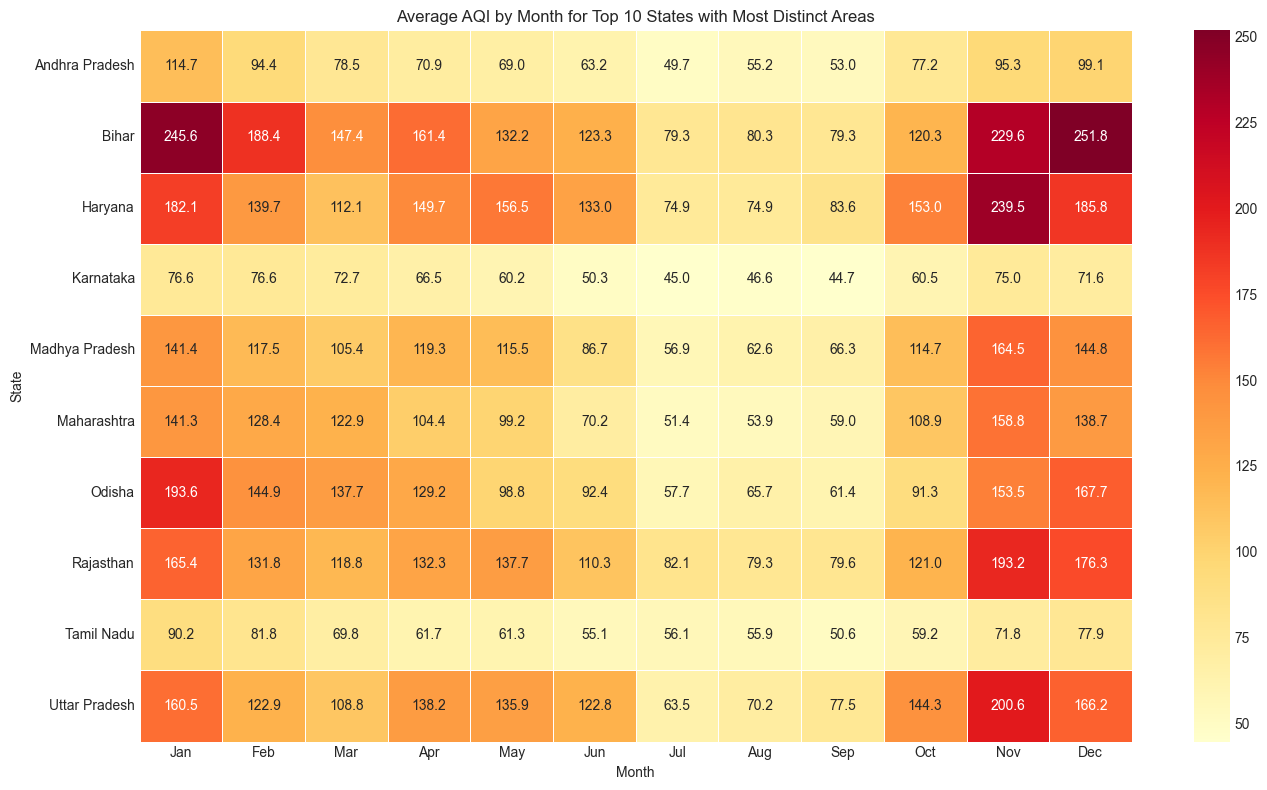

In [33]:
# Merge aqi_fact_table with location_dim to get state information
state_aqi = aqi_fact_table.merge(location_dim, on='location_key', how='left')

# Group by state and month to calculate average AQI
monthly_state_aqi = state_aqi.groupby(['state', 'month_name'])['aqi'].agg(['mean', 'count']).reset_index()

# Get the number of distinct areas per state
distinct_areas = state_aqi.groupby('state')['area'].nunique().reset_index()
distinct_areas = distinct_areas.rename(columns={'area': 'distinct_areas'})

# Merge to get the number of distinct areas for each state
monthly_state_aqi = monthly_state_aqi.merge(distinct_areas, on='state', how='left')

# Filter for top 10 states with highest number of distinct areas
top10_states = distinct_areas.sort_values('distinct_areas', ascending=False).head(10)['state'].tolist()
monthly_state_aqi = monthly_state_aqi[monthly_state_aqi['state'].isin(top10_states)]

# Define a month order for proper sorting
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_state_aqi['month_order'] = monthly_state_aqi['month_name'].apply(lambda x: month_order.index(x))
monthly_state_aqi = monthly_state_aqi.sort_values(['state', 'month_order'])

# Find the worst month for each state based on average AQI
worst_months = monthly_state_aqi.sort_values('mean', ascending=False).groupby('state').head(3)

# Create a pivot table for visualization
month_pivot = monthly_state_aqi.pivot(index='state', columns='month_name', values='mean')
month_pivot = month_pivot[month_order]  # Reorder columns by month

# Display the worst months for air quality
print("Top 10 States by Number of Distinct Areas and Their Worst Months for Air Quality:")
print(worst_months[['state', 'month_name', 'mean', 'distinct_areas']].sort_values(['state', 'mean'], ascending=[True, False]))

# Create a heatmap visualization
plt.figure(figsize=(14, 8))
sns.heatmap(month_pivot, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5)
plt.title('Average AQI by Month for Top 10 States with Most Distinct Areas')
plt.xlabel('Month')
plt.ylabel('State')
plt.tight_layout()
plt.show()